# ODE Modeling of Neuroblast Lineage Growth

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Font size settings for figures
mpl.rcParams.update({
    "font.size": 14,              # base font size
    "axes.titlesize": 16,         # title font
    "axes.labelsize": 14,         # x/y label font
    "xtick.labelsize": 12,        # x-tick labels
    "ytick.labelsize": 12,        # y-tick labels
    "legend.fontsize": 12,        # legend text
    "lines.linewidth": 2,         # line thickness
    "axes.linewidth": 1.2,        # axis border thickness
})

# Function to make annotating data on figures easier
def annotate_final_values(ax, x, y_values, labels, min_sep_frac=0.1):
    """
    Adds annotations at the final time point of each y-series with spacing done in axis-fraction units.

    Parameters:
        ax: matplotlib Axes object
        x: time points (1D array)
        y_values: list of y-arrays
        labels: list of label strings
        min_sep_frac: minimum spacing between annotations in axis fraction (0.03 = 3% of y-axis height)
    """
    final_x = x[-1]
    final_ys = [y[-1] for y in y_values]
    y_min, y_max = ax.get_ylim()

    # Convert y-values to axis-fraction space
    y_fracs = [(y - y_min) / (y_max - y_min) for y in final_ys]

    # Sort and apply minimum spacing in axis-fraction space
    sorted_indices = np.argsort(y_fracs)
    new_frac_positions = {}
    last_frac = None
    for idx in sorted_indices:
        frac = y_fracs[idx]
        if last_frac is None:
            new_frac_positions[idx] = frac
        else:
            new_frac_positions[idx] = max(frac, last_frac + min_sep_frac)
        last_frac = new_frac_positions[idx]

    # Clamp to [0,1] and convert back to data coordinates
    for idx in range(len(y_values)):
        orig_y = final_ys[idx]
        frac_y = min(new_frac_positions[idx], 0.98)  # avoid going out of bounds
        adjusted_y = y_min + frac_y * (y_max - y_min)

        ax.annotate(f"{labels[idx]}\n{orig_y:.0f}",
                    xy=(final_x, orig_y),
                    xytext=(final_x + 1, adjusted_y),
                    textcoords='data',
                    fontsize=8,
                    va='center',
                    ha='left',
                    arrowprops=dict(arrowstyle='->', lw=0.5),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", lw=0.5))


## 1. Modeling Cell Counts

This is a simple ODE model of that tracks the counts of each cell type in the developing neuroblast lineage. This model does not track cell volume and assumes homogeneous behavior within each cell type.

### Model Species
- **$N_{\text{NB}}$** - Number of neuroblasts, neuroblasts are stem-like cells that can divide asymmetrically yielding one neuroblast and one GMC or symmetrically yielding two neuroblasts
- **$N_{\text{GMC}}$** - Number of GMCs, Ganglion Mother Cells are neuron precursors that divide symmetrically into two neurons
- **$N_{\text{ImNeuron}}$** - Number of immature neurons. Immature neurons are terminally differentiated brain cells that do not grow nor divide. they mature into MatNeurons
- **$N_{\text{MatNeuron}}$** - Number of mature neurons. Mature neurons are terminally differentiated brain cells that do not grow, divide, nor change state.

### Model Parameters
- **$k_{\text{NB}}$** - the rate of neuroblast divisions, in units of divisions/hour
- **$k_{\text{GMC}}$** - the rate of GMC divisions, in units of divisions/hour
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour).
- **$\text{sym\_frac}$** - the fraction of neuroblast divisions that are symmetrical. Unitless.
  - Set to 0 for WT simulations and .15 for mudmut simulations

### Model Structure
The number of neuroblasts increases by 1 with each symmetric neuroblast division
$$\frac{dN_{\text{NB}}}{dt} = \text{sym\_frac} * k_{\text{NB}} * N_{\text{NB}}$$

The number of GMCs increases by 1 with each asymmetric neuroblast division and decreases by 1 with each GMC division.
$$\frac{dN_{\text{GMC}}}{dt} = (1 - \text{sym\_frac}) \cdot k_{\text{NB}} N_{\text{NB}} - k_{\text{GMC}} N_{\text{GMC}}$$

Immature neurons increase by 2 per GMC division and decrease as they mature:
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC}} \cdot N_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

Mature neurons increase as immature neurons mature:
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

### Model Limitations
- This model assumes homogeneous populations of neuroblasts, GMCs, and neurons, meaning that all cells within each type behave identically. It does not account for variability in growth rates, cell cycle timing, cell volume, or stochasticity in fate decisions
- This model treats the rates of division as constant over time and independent of population size or environmental feedback
- This model does not track cell volumes

In [3]:
def neuroblast_model(t, y, params):
    N_NB, N_GMC, N_ImNeuron, N_MatNeuron = y
    k_NB, k_GMC, k_Neuron, sym_frac = params  # Division and maturation rates

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # ODEs
    dN_NB = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dN_MatNeuron = k_Neuron * N_ImNeuron

    return [dN_NB, dN_GMC, dN_ImNeuron, dN_MatNeuron]

### WT Simulation
**Parameter Justifications**
- Neuroblast division date - 1 division per 1.5 hours, from literature
- GMC division rate - 1 division per 9 hours, from literature
- Neuron maturation rate - 1 maturation per 48 hours, calibrated to allow WT lineages to have an average of 42 visable cells by the end of 48 hours

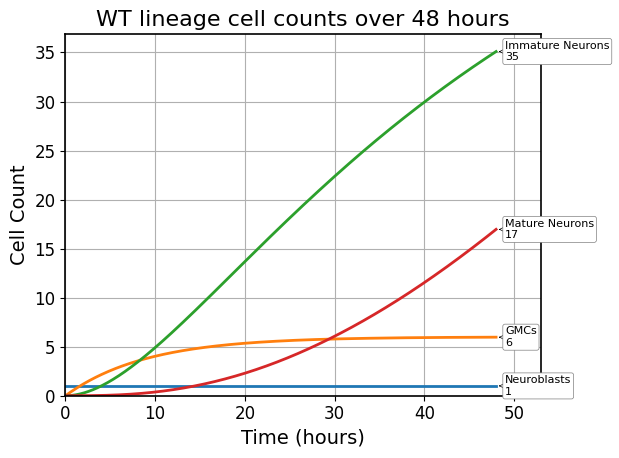

In [4]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,    # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.0      # 0% symmetric NB divisions for WT
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

### mudmut Simulation
**Parameter Justifications**
I left all the parameters the same as the WT simulation except changed the percent symmetric divisions to .15.

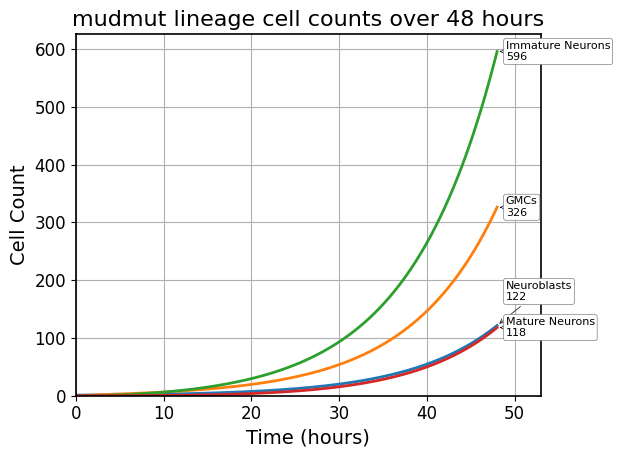

In [5]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,   # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.15      # 15% symmetric NB divisions for mudmut
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

### Conclusion from simple cell count model:
- ODE modling of cell growth and division behavior yields mud colonies with many more cells than wt colonies, which is the opposite of what is observed experimentally

---
## 2. Modeling cell counts with cellcount activating feedback on neuron maturation rate

This ODE model tracks the counts of each cell type in the developing neuroblast lineage and adds **activating feedback on the neuron maturation step** (immature → mature). The feedback depends on the **total number of cells** in the lineage and is modeled with a Hill activation function (setting \(n=1\) recovers a Michaelis–Menten form).

### Model Species
- **$N_{\text{NB}}$** — Number of neuroblasts (NB). Neuroblasts can divide asymmetrically (→ one NB + one GMC) or symmetrically (→ two NBs).
- **$N_{\text{GMC}}$** — Number of Ganglion Mother Cells (GMC). GMCs divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}}$** — Number of immature neurons. These do not grow nor divide; they **mature** into mature neurons.
- **$N_{\text{MatNeuron}}$** — Number of mature neurons. Mature neurons do not grow, divide, or change state.

### Model Parameters
- **$k_{\text{NB}}$** — Neuroblast division rate (divisions/hour).
- **$k_{\text{GMC}}$** — GMC division rate (divisions/hour).
- **$k_{\text{Neuron,max}}$** — Maximum maturation rate from immature to mature neurons (transitions/hour).
- **$K_{\text{feedback}}$** — Half‑max constant (cell count) for maturation feedback based on total lineage size.
- **$n$** — Hill coefficient controlling the steepness of feedback (set \(n=1\) for Michaelis–Menten–like behavior).
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless).
  - Set to 0 for WT simulations and 0.15 for *mud* simulations.

### Model Structure

Let the total cell count be
$$
N_{\text{total}} \;=\; N_{\text{NB}} + N_{\text{GMC}} + N_{\text{ImNeuron}} + N_{\text{MatNeuron}}.
$$

Maturation is activate by total cell count via a Hill function:
$$
k_{\text{Neuron,eff}} \;=\; k_{\text{Neuron,max}} \cdot \frac{K_{\text{total}}^{\,n}}{K_{\text{feedback}}^{\,n} + N_{\text{total}}^{\,n}}.
$$

Divisions and maturation dynamics:
$$
\frac{dN_{\text{NB}}}{dt} \;=\; \text{sym\_frac}\cdot k_{\text{NB}}\, N_{\text{NB}},
$$
$$
\frac{dN_{\text{GMC}}}{dt} \;=\; (1-\text{sym\_frac})\cdot k_{\text{NB}}\, N_{\text{NB}} \;-\; k_{\text{GMC}}\, N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} \;=\; 2\,k_{\text{GMC}}\, N_{\text{GMC}} \;-\; k_{\text{Neuron,eff}}\, N_{\text{ImNeuron}},
$$
$$
\frac{dN_{\text{MatNeuron}}}{dt} \;=\; k_{\text{Neuron,eff}}\, N_{\text{ImNeuron}}.
$$

### Model Limitations
- Assumes homogeneous behavior within each cell type (no cell‑to‑cell variability).
- Uses continuous, deterministic rates (no explicit event timing or stochasticity).
- Feedback is global and based only on **total** cell count (no spatial effects).

In [6]:
def neuroblast_model_with_maturation_feedback(t, y, params):
    """
    ODEs for NB/GMC/neuron counts with Hill-type activation feedback on neuron maturation.

    State vector:
        y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]

    Parameters (tuple/list in this order):
        k_NB            : NB division rate (1/hr)
        k_GMC           : GMC division rate (1/hr)
        k_Neuron_max    : maximum maturation rate (ImNeuron -> MatNeuron) (1/hr)
        K_feedback      : half-max total cell count for maturation feedback
        n               : Hill coefficient (n=1 -> Michaelis–Menten-like)
        sym_frac        : fraction of symmetric NB divisions (unitless)

    Feedback (activation) form:
        k_Neuron_eff = k_Neuron_max * (N_total^n) / (K_feedback^n + N_total^n)
        where N_total = N_NB + N_GMC + N_ImNeuron + N_MatNeuron
    """
    N_NB, N_GMC, N_ImNeuron, N_MatNeuron = y
    k_NB, k_GMC, k_Neuron_max, K_feedback, n, sym_frac = params

    # Total cells for feedback
    N_total = max(N_NB + N_GMC + N_ImNeuron + N_MatNeuron, 0.0)

    # Effective maturation rate with Hill-type repression
    if K_feedback <= 0:
        # Guard: if K_feedback is non-positive, fall back to no feedback
        k_Neuron_eff = k_Neuron_max
    else:
        k_Neuron_eff = k_Neuron_max * (max(N_total, 0.0)**n) / (K_feedback**n + max(N_total, 0.0)**n)

    # NB divisions
    sym_divs  = sym_frac * k_NB * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB * N_NB

    # ODEs
    dN_NB        = sym_divs
    dN_GMC       = asym_divs - k_GMC * N_GMC
    dN_ImNeuron  = 2.0 * k_GMC * N_GMC - k_Neuron_eff * N_ImNeuron
    dN_MatNeuron = k_Neuron_eff * N_ImNeuron

    return [dN_NB, dN_GMC, dN_ImNeuron, dN_MatNeuron]

### WT Simulation
**Parameter Justifications**
- Cell count at which neurons reach half-max maturation rate: 41 - In an attempt to make the neuron maturation rate feedback rate as high as possible, I thought I'd set this value so that the number of cells in the lineage we expect to see at the last timepoint has the differentiation only half-maximally activated.
- Maximum neuron maturation rate: 1/24 hours - I set this to make the WT simulation have 41 visible cells at the last timepoint

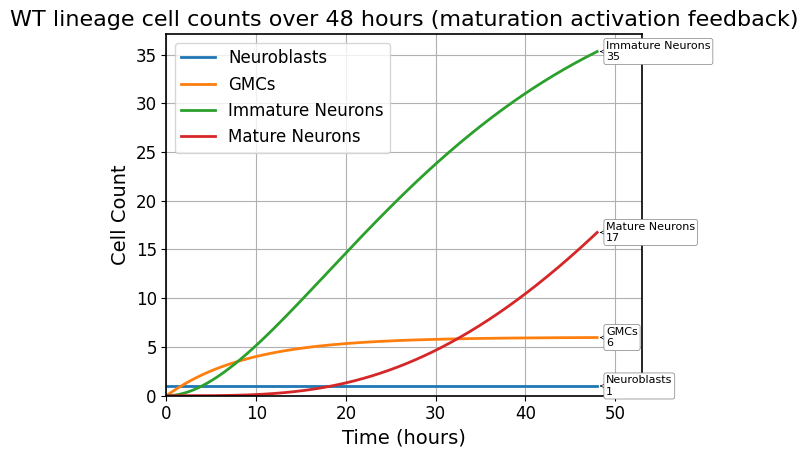

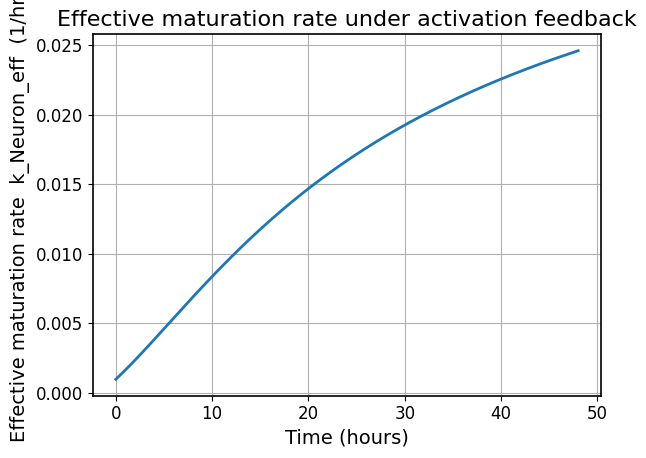

In [7]:
# WT simulation for maturation-activation feedback model

# --- Parameter value assignment ---
k_NB = 1/1.5          # NB divides every 1.5 hrs
k_GMC = 1/9.0         # GMC divides every 9 hrs
k_Neuron_max = 1/24   # Max maturation rate: ImNeuron -> MatNeuron in ~24 hrs
K_feedback = 41       # Half-max activation at ~20 total cells
n = 1                 # Hill coefficient (n=1 => Michaelis–Menten-like activation)
sym_frac = 0.0        # 0% symmetric NB divisions for WT

params = [k_NB, k_GMC, k_Neuron_max, K_feedback, n, sym_frac]

# --- Initial conditions ---
# y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# --- Time span ---
t_span = [0, 48]                          # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# --- Solve ODE ---
sol = solve_ivp(
    neuroblast_model_with_maturation_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# --- Plotting: cell counts ---
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
# Uses your existing helper; comment out if not defined in your notebook
annotate_final_values(ax, sol.t, y_data, labels)

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT lineage cell counts over 48 hours (maturation activation feedback)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# --- plot effective maturation rate over time to verify feedback behavior ---
# Compute k_Neuron_eff(t) for reference
N_total = sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3]
k_eff = k_Neuron_max * (N_total**n) / (K_feedback**n + N_total**n)

fig, ax = plt.subplots()
ax.plot(sol.t, k_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Effective maturation rate  k_Neuron_eff  (1/hr)")
ax.set_title("Effective maturation rate under activation feedback")
ax.grid()
plt.tight_layout()
plt.show()

### mudmut Simulation
**Parameter Justification**
- fraction of symmetrical divisions: .15 - capturing mudmut dynamics

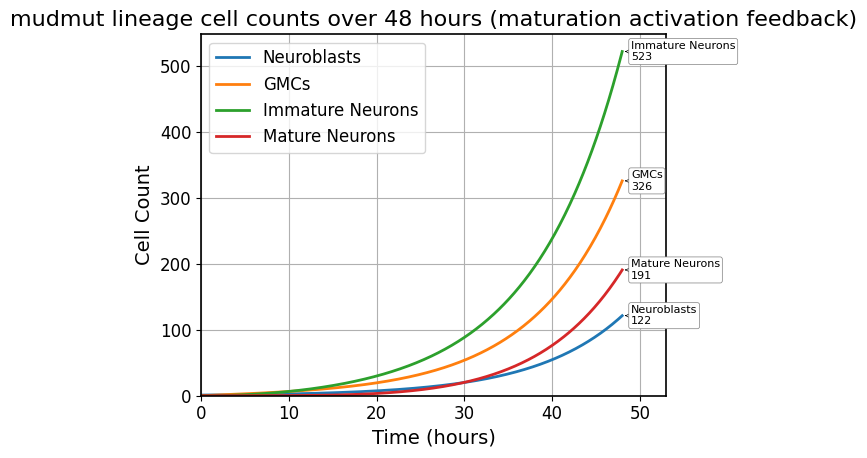

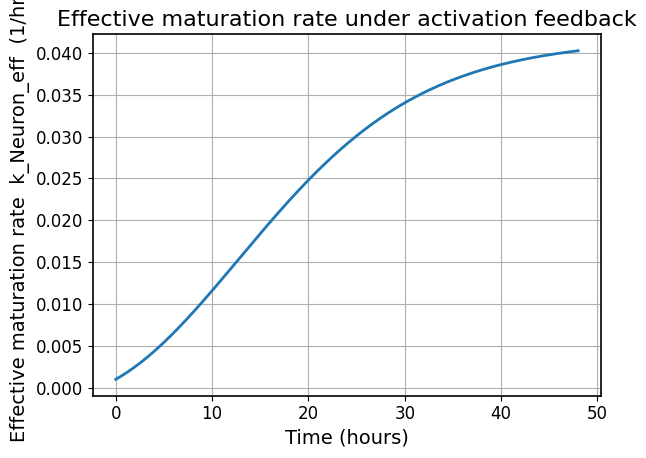

In [8]:
# mudmut simulation for maturation-activation feedback model

# --- Parameter value assignment ---
k_NB = 1/1.5          # NB divides every 1.5 hrs
k_GMC = 1/9.0         # GMC divides every 9 hrs
k_Neuron_max = 1/24   # Max maturation rate: ImNeuron -> MatNeuron in ~24 hrs
K_feedback = 41       # Half-max activation at ~20 total cells
n = 1                 # Hill coefficient (n=1 => Michaelis–Menten-like activation)
sym_frac = 0.15       # 15% symmetric NB divisions for mudmut

params = [k_NB, k_GMC, k_Neuron_max, K_feedback, n, sym_frac]

# --- Initial conditions ---
# y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# --- Time span ---
t_span = [0, 48]                          # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# --- Solve ODE ---
sol = solve_ivp(
    neuroblast_model_with_maturation_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# --- Plotting: cell counts ---
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
# Uses your existing helper; comment out if not defined in your notebook
annotate_final_values(ax, sol.t, y_data, labels)

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut lineage cell counts over 48 hours (maturation activation feedback)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# --- plot effective maturation rate over time to verify feedback behavior ---
# Compute k_Neuron_eff(t) for reference
N_total = sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3]
k_eff = k_Neuron_max * (N_total**n) / (K_feedback**n + N_total**n)

fig, ax = plt.subplots()
ax.plot(sol.t, k_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Effective maturation rate  k_Neuron_eff  (1/hr)")
ax.set_title("Effective maturation rate under activation feedback")
ax.grid()
plt.tight_layout()
plt.show()

### Conclusions:
- Still insufficient feedback

---
<a id="cellcountsneurondiffcellcountdownnbdiv"></a>

## 3. Cell-Count–Coupled Model: Neuron Maturation Activation + NB Division Repression

This model extends the count-only lineage ODEs by coupling two processes to **total lineage size** $N_{\text{total}}$:
- **Activation** of immature→mature neuron maturation as $N_{\text{total}}$ increases.
- **Repression** of neuroblast (NB) division as $N_{\text{total}}$ increases.

This lets the lineage **accelerate differentiation** while **slowing stem-like expansion** as it becomes larger.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts.
- **$N_{\text{GMC}}$** — Ganglion Mother Cells.
- **$N_{\text{ImNeuron}}$** — Immature neurons.
- **$N_{\text{MatNeuron}}$** — Mature neurons.

### Model Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr).
- **$k_{\text{GMC}}$** — GMC division rate (1/hr).
- **$k_{\text{Neuron,max}}$** — Max maturation rate (1/hr).
- **$K_{\text{div}},\, n_{\text{div}}$** — Half-max constant & Hill coefficient for **NB division repression**.
- **$K_{\text{mat}},\, n_{\text{mat}}$** — Half-max constant & Hill coefficient for **maturation activation**.
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless).

### Feedback Forms (with $N_{\text{total}}=N_{\text{NB}}+N_{\text{GMC}}+N_{\text{ImNeuron}}+N_{\text{MatNeuron}}$)
**NB division (repression):**
$$
k_{\text{NB,eff}} \;=\; k_{\text{NB,max}}\;\frac{K_{\text{div}}^{\,n_{\text{div}}}}{K_{\text{div}}^{\,n_{\text{div}}} + N_{\text{total}}^{\,n_{\text{div}}}}
$$

**Neuron maturation (activation):**
$$
k_{\text{Neuron,eff}} \;=\; k_{\text{Neuron,max}}\;\frac{N_{\text{total}}^{\,n_{\text{mat}}}}{K_{\text{mat}}^{\,n_{\text{mat}}} + N_{\text{total}}^{\,n_{\text{mat}}}}
$$

### ODEs
Let $text{sym\_frac}\in[0,1]$, then per-unit-time symmetric and asymmetric NB divisions are:
$$
\text{sym\_divs}= \text{sym\_frac}\;k_{\text{NB,eff}}\,N_{\text{NB}},\qquad
\text{asym\_divs}= (1-\text{sym\_frac})\;k_{\text{NB,eff}}\,N_{\text{NB}}.
$$
Population dynamics:
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs}, \qquad
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC}}\,N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2\,k_{\text{GMC}}\,N_{\text{GMC}} - k_{\text{Neuron,eff}}\,N_{\text{ImNeuron}},\qquad
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron,eff}}\,N_{\text{ImNeuron}}.
$$

### Notes
- Set $n_{\text{div}}=1$ or $n_{\text{mat}}=1$ to recover Michaelis–Menten–like responses; larger \(n\) yields more switch-like behavior.
- This is a **count-only** model (no volume tracking).

In [9]:
# Model: maturation activation + NB division repression by total cell count
def neuroblast_model_maturation_activation_and_division_repression(t, y, params):
    """
    y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
    params = [
        k_NB_max,       # max NB division rate (1/hr)
        k_GMC,          # GMC division rate (1/hr)
        k_Neuron_max,   # max maturation rate (1/hr)
        K_div, n_div,   # repression params for NB division
        K_mat, n_mat,   # activation params for maturation
        sym_frac        # fraction of symmetric NB divisions
    ]
    """
    N_NB, N_GMC, N_Im, N_Mat = y
    (k_NB_max, k_GMC, k_Neuron_max,
     K_div, n_div, K_mat, n_mat,
     sym_frac) = params

    # Total cells for feedback
    N_total = max(N_NB + N_GMC + N_Im + N_Mat, 0.0)

    # NB division repression (Hill-type)
    if K_div <= 0:
        k_NB_eff = k_NB_max
    else:
        k_NB_eff = k_NB_max * (K_div**n_div) / (K_div**n_div + N_total**n_div)

    # Neuron maturation activation (Hill-type)
    if K_mat <= 0:
        k_Neuron_eff = k_Neuron_max
    else:
        k_Neuron_eff = k_Neuron_max * (N_total**n_mat) / (K_mat**n_mat + N_total**n_mat)

    # Division flows
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB        = sym_divs
    dN_GMC       = asym_divs - k_GMC * N_GMC
    dN_Im        = 2.0 * k_GMC * N_GMC - k_Neuron_eff * N_Im
    dN_Mat       = k_Neuron_eff * N_Im

    return [dN_NB, dN_GMC, dN_Im, dN_Mat]

### WT Simulation
**Parameter Justifications**
- cell count at which neuron division repression is half-maximal : 41 - making it the same as the half-max activation of neuron maturation to start
- max neuron division rate: 60 mins - calibrated to the quarter hour that got the output closest to 41 visable cells at the last time point

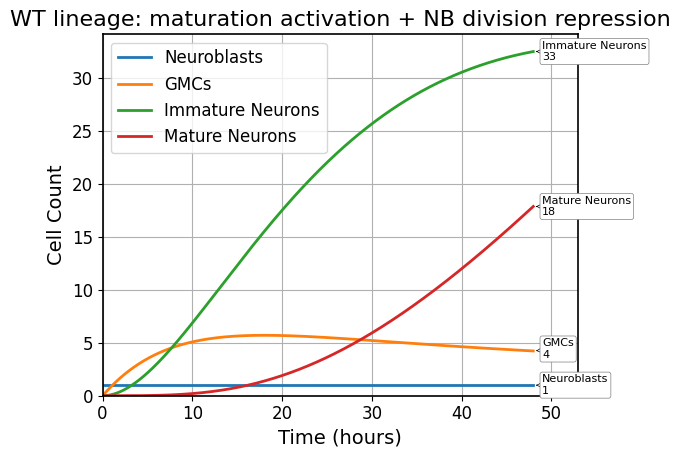

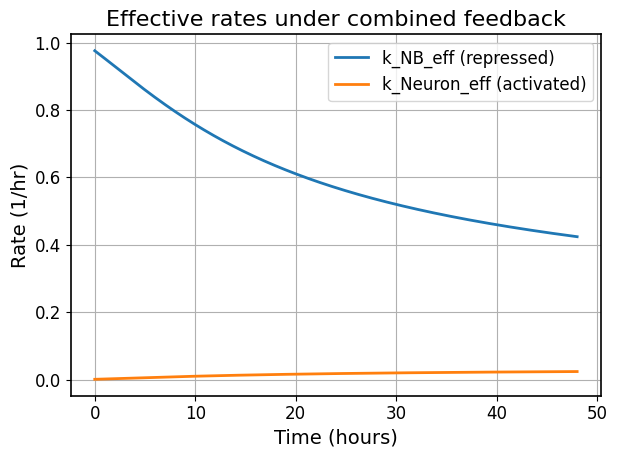

In [10]:
# --- WT simulation cell ---

# Baseline parameters (tweak K_div/K_mat and n's to explore behaviors)
k_NB_max     = 1 / 1    # NB could divide every 60 mins at small N_total
k_GMC        = 1 / 9.0    # GMC divides every 9 h
k_Neuron_max = 1 / 24.0   # Max maturation ~24 h
K_div, n_div = 41.0, 1    # repression half-max & Hill coeff for NB division
K_mat, n_mat = 41.0, 1    # activation half-max & Hill coeff for maturation
sym_frac     = 0.0        # WT asymmetric divisions

params = [k_NB_max, k_GMC, k_Neuron_max, K_div, n_div, K_mat, n_mat, sym_frac]

# Initial conditions and integration
y0 = [1, 0, 0, 0]      # start with one NB
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_maturation_activation_and_division_repression,
    t_span, y0, t_eval=t_eval, args=(params,),
    # method='LSODA'  # uncomment if you encounter stiffness
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, label in zip(series, labels):
    ax.plot(sol.t, s, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if helper is defined in your notebook
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT lineage: maturation activation + NB division repression")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# visualize effective rates over time
N_total = sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3]
k_NB_eff = k_NB_max * (K_div**n_div) / (K_div**n_div + N_total**n_div)
k_Neuron_eff = k_Neuron_max * (N_total**n_mat) / (K_mat**n_mat + N_total**n_mat)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff, label="k_NB_eff (repressed)")
ax.plot(sol.t, k_Neuron_eff, label="k_Neuron_eff (activated)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Rate (1/hr)")
ax.set_title("Effective rates under combined feedback")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

### mudmut Simulation

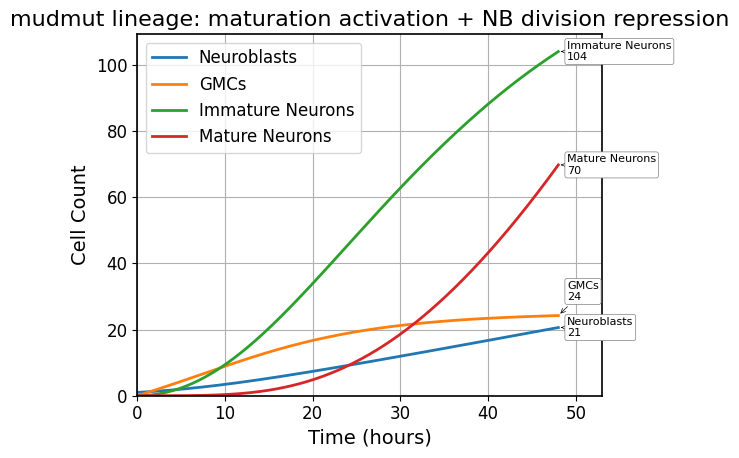

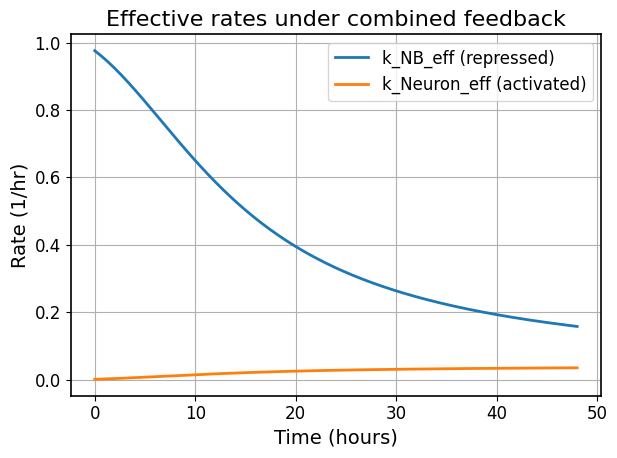

In [11]:
# --- WT simulation cell ---

# Baseline parameters (tweak K_div/K_mat and n's to explore behaviors)
k_NB_max     = 1 / 1    # NB could divide every 60 mins at small N_total
k_GMC        = 1 / 9.0    # GMC divides every 9 h
k_Neuron_max = 1 / 24.0   # Max maturation ~24 h
K_div, n_div = 41.0, 1    # repression half-max & Hill coeff for NB division
K_mat, n_mat = 41.0, 1    # activation half-max & Hill coeff for maturation
sym_frac     = 0.15        # WT asymmetric divisions

params = [k_NB_max, k_GMC, k_Neuron_max, K_div, n_div, K_mat, n_mat, sym_frac]

# Initial conditions and integration
y0 = [1, 0, 0, 0]      # start with one NB
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_maturation_activation_and_division_repression,
    t_span, y0, t_eval=t_eval, args=(params,),
    # method='LSODA'  # uncomment if you encounter stiffness
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, label in zip(series, labels):
    ax.plot(sol.t, s, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if helper is defined in your notebook
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut lineage: maturation activation + NB division repression")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# visualize effective rates over time
N_total = sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3]
k_NB_eff = k_NB_max * (K_div**n_div) / (K_div**n_div + N_total**n_div)
k_Neuron_eff = k_Neuron_max * (N_total**n_mat) / (K_mat**n_mat + N_total**n_mat)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff, label="k_NB_eff (repressed)")
ax.plot(sol.t, k_Neuron_eff, label="k_Neuron_eff (activated)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Rate (1/hr)")
ax.set_title("Effective rates under combined feedback")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

---
<a id="cellcountsneurondiffcellcountdownnbdivdowngmcdiv"></a>

## 4. Cell-Count–Coupled Model: NB Division Repression + GMC Division Repression + Neuron Maturation Activation

This model extends the count-only neuroblast lineage ODEs by coupling three processes to **total lineage size** $N_{\text{total}}$:

- **Repression** of **neuroblast (NB) division** as $N_{\text{total}}$ increases.
- **Repression** of **ganglion mother cell (GMC) division** as $N_{\text{total}}$ increases.
- **Activation** of **immature→mature neuron maturation** as $N_{\text{total}}$ increases.

This formulation mimics a scenario where larger lineages slow their expansion (both NB and GMC proliferation) while accelerating terminal differentiation.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts.
- **$N_{\text{GMC}}$** — Ganglion Mother Cells.
- **$N_{\text{ImNeuron}}$** — Immature neurons.
- **$N_{\text{MatNeuron}}$** — Mature neurons.

### Model Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr).
- **$k_{\text{GMC,max}}$** — Max GMC division rate (1/hr).
- **$k_{\text{Neuron,max}}$** — Max maturation rate (1/hr).
- **$K_{\text{div,NB}}, n_{\text{div,NB}}$** — Half-max constant & Hill coefficient for **NB division repression**.
- **$K_{\text{div,GMC}}, n_{\text{div,GMC}}$** — Half-max constant & Hill coefficient for **GMC division repression**.
- **$K_{\text{mat}}, n_{\text{mat}}$** — Half-max constant & Hill coefficient for **maturation activation**.
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless).

### Feedback Forms
Let $$N_{\text{total}}=N_{\text{NB}}+N_{\text{GMC}}+N_{\text{ImNeuron}}+N_{\text{MatNeuron}}$$.

**NB division (repression):**
$$
k_{\text{NB,eff}} = k_{\text{NB,max}} \cdot \frac{K_{\text{div,NB}}^{n_{\text{div,NB}}}}{K_{\text{div,NB}}^{n_{\text{div,NB}}} + N_{\text{total}}^{n_{\text{div,NB}}}}
$$

**GMC division (repression):**
$$
k_{\text{GMC,eff}} = k_{\text{GMC,max}} \cdot \frac{K_{\text{div,GMC}}^{n_{\text{div,GMC}}}}{K_{\text{div,GMC}}^{n_{\text{div,GMC}}} + N_{\text{total}}^{n_{\text{div,GMC}}}}
$$

**Neuron maturation (activation):**
$$
k_{\text{Neuron,eff}} = k_{\text{Neuron,max}} \cdot \frac{N_{\text{total}}^{n_{\text{mat}}}}{K_{\text{mat}}^{n_{\text{mat}}} + N_{\text{total}}^{n_{\text{mat}}}}
$$

### ODEs
With \(\text{sym\_frac} \in [0,1]\):
$$
\text{sym\_divs} = \text{sym\_frac} \cdot k_{\text{NB,eff}} \cdot N_{\text{NB}}, \quad
\text{asym\_divs} = (1 - \text{sym\_frac}) \cdot k_{\text{NB,eff}} \cdot N_{\text{NB}}.
$$

$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs}
$$
$$
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC,eff}} \cdot N_{\text{GMC}}
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC,eff}} \cdot N_{\text{GMC}} - k_{\text{Neuron,eff}} \cdot N_{\text{ImNeuron}}
$$
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron,eff}} \cdot N_{\text{ImNeuron}}
$$

### Notes
- Set $n=1$ for Michaelis–Menten–like behavior or larger for more switch-like feedback.
- This is a **count-only** model (no volume tracking).

In [12]:
# Model: repression on NB and GMC division, activation on neuron maturation
def neuroblast_model_double_repression_maturation_activation(t, y, params):
    """
    y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
    params = [
        k_NB_max,        # max NB division rate (1/hr)
        k_GMC_max,       # max GMC division rate (1/hr)
        k_Neuron_max,    # max maturation rate (1/hr)
        K_div_NB, n_div_NB,     # NB division repression params
        K_div_GMC, n_div_GMC,   # GMC division repression params
        K_mat, n_mat,           # maturation activation params
        sym_frac                # fraction of symmetric NB divisions
    ]
    """
    N_NB, N_GMC, N_Im, N_Mat = y
    (k_NB_max, k_GMC_max, k_Neuron_max,
     K_div_NB, n_div_NB, K_div_GMC, n_div_GMC,
     K_mat, n_mat,
     sym_frac) = params

    # Total cells for feedback
    N_total = max(N_NB + N_GMC + N_Im + N_Mat, 0.0)

    # NB division repression
    if K_div_NB <= 0:
        k_NB_eff = k_NB_max
    else:
        k_NB_eff = k_NB_max * (K_div_NB**n_div_NB) / (K_div_NB**n_div_NB + N_total**n_div_NB)

    # GMC division repression
    if K_div_GMC <= 0:
        k_GMC_eff = k_GMC_max
    else:
        k_GMC_eff = k_GMC_max * (K_div_GMC**n_div_GMC) / (K_div_GMC**n_div_GMC + N_total**n_div_GMC)

    # Neuron maturation activation
    if K_mat <= 0:
        k_Neuron_eff = k_Neuron_max
    else:
        k_Neuron_eff = k_Neuron_max * (N_total**n_mat) / (K_mat**n_mat + N_total**n_mat)

    # Division flows
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB  = sym_divs
    dN_GMC = asym_divs - k_GMC_eff * N_GMC
    dN_Im  = 2.0 * k_GMC_eff * N_GMC - k_Neuron_eff * N_Im
    dN_Mat = k_Neuron_eff * N_Im

    return [dN_NB, dN_GMC, dN_Im, dN_Mat]

### WT Simulation
**Parameter justifictions**
- cell count at which GMC repression is half-maximal : 41 - kept this consistent with other cell-count half-maximal thresholds
- max GMC division rate : 1/8 hours - I set this to a whole number less than 9 (which we expect to be the average) that yielded cell counts near 41

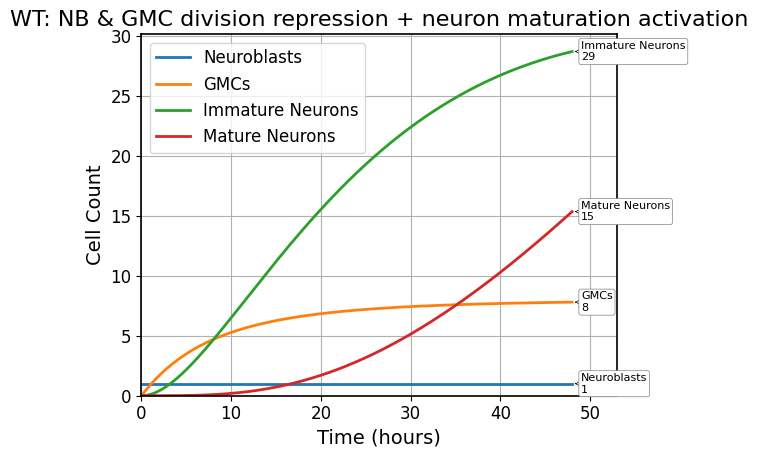

In [13]:
# --- WT simulation cell ---

# Parameters
k_NB_max   = 1 / 1      # max NB division rate 1 per hr
k_GMC_max  = 1 / 8.0    # max GMC division rate
k_Neuron_max = 1 / 24.0 # max maturation rate 1 per 24 hours

# Feedback params
K_div_NB, n_div_NB   = 41.0, 1
K_div_GMC, n_div_GMC = 41.0, 1
K_mat, n_mat         = 41.0, 1

sym_frac = 0.0 # WT

params = [
    k_NB_max, k_GMC_max, k_Neuron_max,
    K_div_NB, n_div_NB,
    K_div_GMC, n_div_GMC,
    K_mat, n_mat,
    sym_frac
]

# Initial conditions
y0 = [1, 0, 0, 0]  # start with one NB
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Solve
sol = solve_ivp(
    neuroblast_model_double_repression_maturation_activation,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, label in zip(series, labels):
    ax.plot(sol.t, s, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT: NB & GMC division repression + neuron maturation activation")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

### mudmut simulation

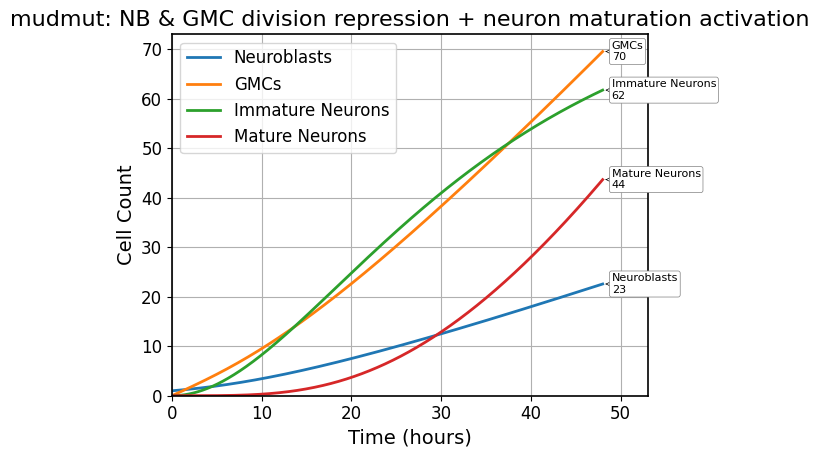

In [14]:
# --- WT simulation cell ---

# Parameters
k_NB_max   = 1 / 1      # max NB division rate 1 per hr
k_GMC_max  = 1 / 8.0    # max GMC division rate
k_Neuron_max = 1 / 24.0 # max maturation rate 1 per 24 hours

# Feedback params
K_div_NB, n_div_NB   = 41.0, 1
K_div_GMC, n_div_GMC = 41.0, 1
K_mat, n_mat         = 41.0, 1

sym_frac = 0.15 # mudmut

params = [
    k_NB_max, k_GMC_max, k_Neuron_max,
    K_div_NB, n_div_NB,
    K_div_GMC, n_div_GMC,
    K_mat, n_mat,
    sym_frac
]

# Initial conditions
y0 = [1, 0, 0, 0]  # start with one NB
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Solve
sol = solve_ivp(
    neuroblast_model_double_repression_maturation_activation,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, label in zip(series, labels):
    ax.plot(sol.t, s, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut: NB & GMC division repression + neuron maturation activation")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

---

## 5. Cell-Count–Coupled Model: NB Division **Repression** (Global + NB‑Self), GMC Division **Repression**, Neuron Maturation **Activation**

This model extends the count‑only lineage ODEs by coupling **three** processes to **total lineage cell count** $N_{\text{total}}$ and adding an **NB‑self repression** term:

- **NB division** is **repressed** by:
  1) **Total lineage cell count** $N_{\text{total}}$, and
  2) **NB count itself** $N_{\text{NB}}$ (autocrine/density‑dependent NB self‑limitation).
- **GMC division** is **repressed** by $N_{\text{total}}$.
- **Neuron maturation** (immature -> mature) is **activated** by $N_{\text{total}}$.

This captures a scenario where growing lineages slow both stem‑like and progenitor proliferation, while accelerating terminal differentiation; additionally, high NB density further suppresses NB self‑renewal.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts
- **$N_{\text{GMC}}$** — Ganglion Mother Cells
- **$N_{\text{ImNeuron}}$** — Immature neurons
- **$N_{\text{MatNeuron}}$** — Mature neurons

### Model Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr)
- **$k_{\text{GMC,max}}$** — Max GMC division rate (1/hr)
- **$k_{\text{Neuron,max}}$** — Max maturation rate (1/hr)
- **$K_{\text{div,NB}},\,n_{\text{div,NB}}$** — Total‑count repression for NB division
- **$K_{\text{div,NB,self}},\,n_{\text{div,NB,self}}$** — **NB‑self** repression for NB division
- **$K_{\text{div,GMC}},\,n_{\text{div,GMC}}$** — Total‑count repression for GMC division
- **$K_{\text{mat}},\,n_{\text{mat}}$** — Total‑count activation for maturation
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless)

### Feedback Forms
Let $$N_{\text{total}} = N_{\text{NB}} + N_{\text{GMC}} + N_{\text{ImNeuron}} + N_{\text{MatNeuron}}$$.

**NB division (combined repression; multiplicative):**
$$
k_{\text{NB,eff}} \;=\; k_{\text{NB,max}}
\;\underbrace{\frac{K_{\text{div,NB}}^{\,n_{\text{div,NB}}}}{K_{\text{div,NB}}^{\,n_{\text{div,NB}}} + N_{\text{total}}^{\,n_{\text{div,NB}}}}}_{\text{global repression}}
\;\underbrace{\frac{K_{\text{div,NB,self}}^{\,n_{\text{div,NB,self}}}}{K_{\text{div,NB,self}}^{\,n_{\text{div,NB,self}}} + N_{\text{NB}}^{\,n_{\text{div,NB,self}}}}}_{\text{NB‑self repression}}
$$

**GMC division (repression by total count):**
$$
k_{\text{GMC,eff}} \;=\; k_{\text{GMC,max}} \cdot \frac{K_{\text{div,GMC}}^{\,n_{\text{div,GMC}}}}{K_{\text{div,GMC}}^{\,n_{\text{div,GMC}}} + N_{\text{total}}^{\,n_{\text{div,GMC}}}}
$$

**Neuron maturation (activation by total count):**
$$
k_{\text{Neuron,eff}} \;=\; k_{\text{Neuron,max}} \cdot \frac{N_{\text{total}}^{\,n_{\text{mat}}}}{K_{\text{mat}}^{\,n_{\text{mat}}} + N_{\text{total}}^{\,n_{\text{mat}}}}
$$

### ODEs
With $\text{sym\_frac}\in[0,1]$,
$$
\text{sym\_divs} = \text{sym\_frac}\,k_{\text{NB,eff}}\,N_{\text{NB}},\qquad
\text{asym\_divs} = (1-\text{sym\_frac})\,k_{\text{NB,eff}}\,N_{\text{NB}}.
$$
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs}, \quad
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC,eff}}\,N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2\,k_{\text{GMC,eff}}\,N_{\text{GMC}} - k_{\text{Neuron,eff}}\,N_{\text{ImNeuron}}, \quad
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron,eff}}\,N_{\text{ImNeuron}}.
$$

**Notes:** Set any $n=1$ to obtain a Michaelis–Menten–like response; larger $n$ yields a sharper, switch‑like response. Set a large $K$ to effectively “disable” that feedback branch.

In [15]:
# Model: NB division repression = global * NB-self; GMC division repression (global); maturation activation (global)
def neuroblast_model_division_double_repression_with_NB_self(t, y, params):
    """
    y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]

    params = [
        k_NB_max, k_GMC_max, k_Neuron_max,   # max rates (1/hr)
        K_div_NB, n_div_NB,                  # NB division repression by N_total
        K_div_NB_self, n_div_NB_self,        # NB division repression by N_NB (self)
        K_div_GMC, n_div_GMC,                # GMC division repression by N_total
        K_mat, n_mat,                        # maturation activation by N_total
        sym_frac
    ]
    """
    (N_NB, N_GMC, N_Im, N_Mat) = y
    (k_NB_max, k_GMC_max, k_Neuron_max,
     K_div_NB, n_div_NB,
     K_div_NB_self, n_div_NB_self,
     K_div_GMC, n_div_GMC,
     K_mat, n_mat,
     sym_frac) = params

    # Totals
    N_total = max(N_NB + N_GMC + N_Im + N_Mat, 0.0)

    # Helper to avoid zero/negative K
    def hill_repress(K, n, x):
        if K is None or K <= 0:
            return 1.0
        return (K**n) / (K**n + max(x, 0.0)**n)

    def hill_activate(K, n, x):
        if K is None or K <= 0:
            return 1.0
        return (max(x, 0.0)**n) / (K**n + max(x, 0.0)**n)

    # Effective rates
    k_NB_eff   = k_NB_max  * hill_repress(K_div_NB,     n_div_NB,     N_total) \
                            * hill_repress(K_div_NB_self,n_div_NB_self,N_NB)
    k_GMC_eff  = k_GMC_max * hill_repress(K_div_GMC,    n_div_GMC,    N_total)
    k_Neur_eff = k_Neuron_max * hill_activate(K_mat,    n_mat,        N_total)

    # Flows
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB  = sym_divs
    dN_GMC = asym_divs - k_GMC_eff * N_GMC
    dN_Im  = 2.0 * k_GMC_eff * N_GMC - k_Neur_eff * N_Im
    dN_Mat = k_Neur_eff * N_Im

    return [dN_NB, dN_GMC, dN_Im, dN_Mat]

### WT Simulation

**Parameter Justification**
- number of neuroblasts at which neuroblast division is half-maximally supressed: 2 - minimal number of neuroblasts
- hill coefficient for neuroblast-number based repression of neuroblast division: 6 - want to make this switch-like so there is little to no repression at less than 2 neuroblasts and a lot of repression at higher than 2 neuroblasts

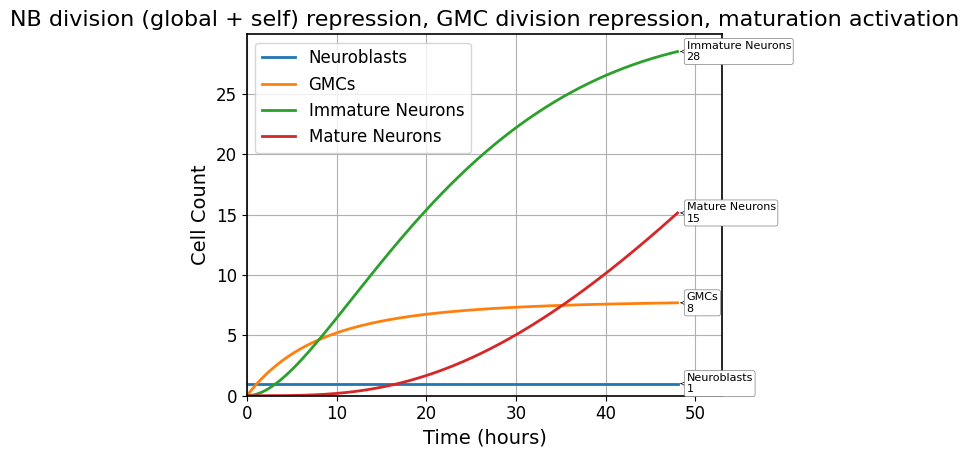

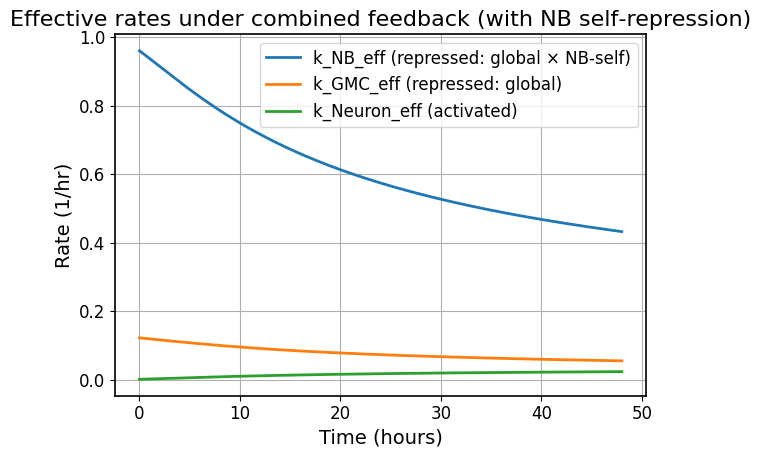

In [16]:
# Baseline max rates (consistent with prior choices)
k_NB_max   = 1 / 1      # max NB division rate 1 per hr
k_GMC_max  = 1 / 8.0    # max GMC division rate
k_Neuron_max = 1 / 24.0 # max maturation rate 1 per 24 hours

# Feedback params
K_div_NB, n_div_NB         = 41.0, 1   # NB division repressed by total count
K_div_NB_self, n_div_NB_self = 2.0, 6  # NB division additionally repressed by NB count, switch-like repression
K_div_GMC, n_div_GMC       = 41.0, 1   # GMC division repressed by total count
K_mat, n_mat               = 41.0, 1   # maturation activated by total count

sym_frac = 0.0  # WT asymmetric divisions

params = [k_NB_max, k_GMC_max, k_Neuron_max,
          K_div_NB, n_div_NB,
          K_div_NB_self, n_div_NB_self,
          K_div_GMC, n_div_GMC,
          K_mat, n_mat,
          sym_frac]

# Initial condition and time grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_division_double_repression_with_NB_self,
    t_span, y0, t_eval=t_eval, args=(params,),
)

# Plot
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]
for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("NB division (global + self) repression, GMC division repression, maturation activation")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# visualize effective rates over time
N_total = sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3]
def hill_repress_series(K, n, x): return (K**n)/(K**n + x**n) if K>0 else 1.0
def hill_activate_series(K, n, x): return (x**n)/(K**n + x**n) if K>0 else 1.0

k_NB_eff  = k_NB_max  * hill_repress_series(K_div_NB, n_div_NB, N_total) \
                        * hill_repress_series(K_div_NB_self, n_div_NB_self, sol.y[0])
k_GMC_eff = k_GMC_max * hill_repress_series(K_div_GMC, n_div_GMC, N_total)
k_Neur_eff= k_Neuron_max * hill_activate_series(K_mat, n_mat, N_total)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff,  label="k_NB_eff (repressed: global × NB‑self)")
ax.plot(sol.t, k_GMC_eff, label="k_GMC_eff (repressed: global)")
ax.plot(sol.t, k_Neur_eff,label="k_Neuron_eff (activated)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Rate (1/hr)")
ax.set_title("Effective rates under combined feedback (with NB self‑repression)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

### mudmut simulation

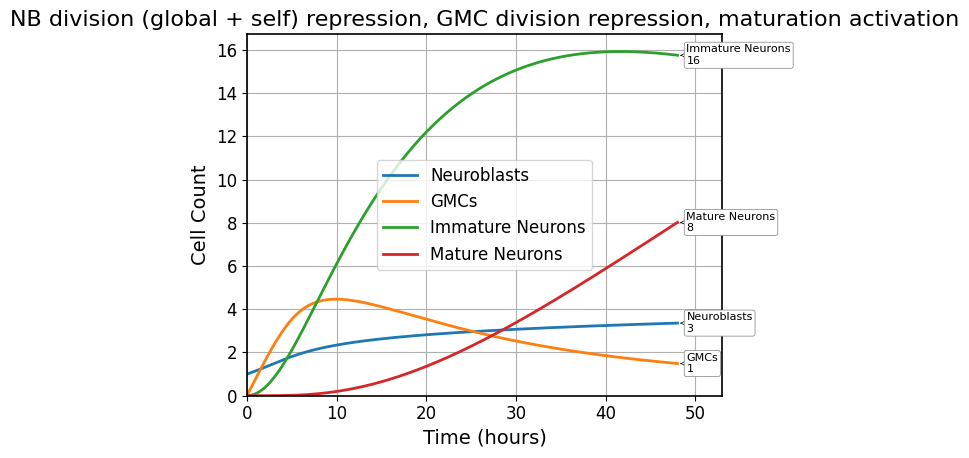

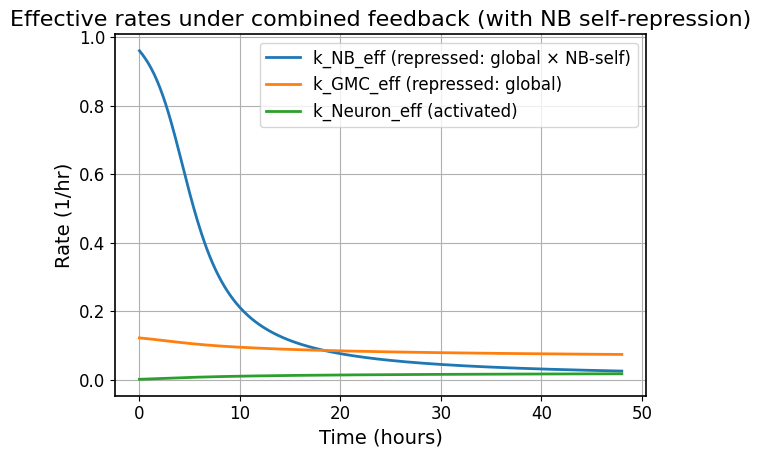

In [17]:
# Baseline max rates (consistent with prior choices)
k_NB_max   = 1 / 1      # max NB division rate 1 per hr
k_GMC_max  = 1 / 8.0    # max GMC division rate
k_Neuron_max = 1 / 24.0 # max maturation rate 1 per 24 hours

# Feedback params
K_div_NB, n_div_NB         = 41.0, 1   # NB division repressed by total count
K_div_NB_self, n_div_NB_self = 2.0, 6  # NB division additionally repressed by NB count, switch-like repression
K_div_GMC, n_div_GMC       = 41.0, 1   # GMC division repressed by total count
K_mat, n_mat               = 41.0, 1   # maturation activated by total count

sym_frac = 0.15  # mudmut asymmetric divisions

params = [k_NB_max, k_GMC_max, k_Neuron_max,
          K_div_NB, n_div_NB,
          K_div_NB_self, n_div_NB_self,
          K_div_GMC, n_div_GMC,
          K_mat, n_mat,
          sym_frac]

# Initial condition and time grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_division_double_repression_with_NB_self,
    t_span, y0, t_eval=t_eval, args=(params,),
)

# Plot
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]
for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("NB division (global + self) repression, GMC division repression, maturation activation")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# visualize effective rates over time
N_total = sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3]
def hill_repress_series(K, n, x): return (K**n)/(K**n + x**n) if K>0 else 1.0
def hill_activate_series(K, n, x): return (x**n)/(K**n + x**n) if K>0 else 1.0

k_NB_eff  = k_NB_max  * hill_repress_series(K_div_NB, n_div_NB, N_total) \
                        * hill_repress_series(K_div_NB_self, n_div_NB_self, sol.y[0])
k_GMC_eff = k_GMC_max * hill_repress_series(K_div_GMC, n_div_GMC, N_total)
k_Neur_eff= k_Neuron_max * hill_activate_series(K_mat, n_mat, N_total)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff,  label="k_NB_eff (repressed: global × NB‑self)")
ax.plot(sol.t, k_GMC_eff, label="k_GMC_eff (repressed: global)")
ax.plot(sol.t, k_Neur_eff,label="k_Neuron_eff (activated)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Rate (1/hr)")
ax.set_title("Effective rates under combined feedback (with NB self‑repression)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

**CONCLUSION:** This set of feedback DOES yield dynamics where mud mutant lineages have fewer cells than WT! Lets simplify the model to just the nb down-regulation and see if that has the same effect.

---

## 6. NB Self‑Repression Only: Simple Count Model

In this simplified model, only **neuroblast (NB) division** is down‑regulated by the **number of NBs**. GMC division and neuron maturation proceed at fixed rates. This isolates the effect of NB density on its own self‑renewal.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts
- **$N_{\text{GMC}}$** — Ganglion Mother Cells
- **$N_{\text{ImNeuron}}$** — Immature Neurons
- **$N_{\text{MatNeuron}}$** — Mature Neurons

### Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr)
- **$k_{\text{GMC}}$** — GMC division rate (1/hr)
- **$k_{\text{Neuron}}$** — Maturation rate (1/hr)
- **$K_{\text{NB,self}},\, n_{\text{self}}$** — Half‑max constant & Hill coefficient for **NB self‑repression**
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless)

### Feedback (NB self‑repression only)
$$
k_{\text{NB,eff}} \;=\; k_{\text{NB,max}} \cdot
\frac{K_{\text{NB,self}}^{\,n_{\text{self}}}}{K_{\text{NB,self}}^{\,n_{\text{self}}} + N_{\text{NB}}^{\,n_{\text{self}}}}
$$

### ODEs
$$
\text{sym\_divs} = \text{sym\_frac}\,k_{\text{NB,eff}}\,N_{\text{NB}},\qquad
\text{asym\_divs} = (1-\text{sym\_frac})\,k_{\text{NB,eff}}\,N_{\text{NB}}.
$$
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs},\quad
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC}}\,N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2\,k_{\text{GMC}}\,N_{\text{GMC}} - k_{\text{Neuron}}\,N_{\text{ImNeuron}},\quad
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}}\,N_{\text{ImNeuron}}.
$$

**Notes:** Set $n_{\text{self}}=1$ for Michaelis–Menten–like self‑repression; larger $n_{\text{self}}$ yields a sharper, switch‑like response.

In [18]:
# ---- Model: NB self-repression only (counts) ----
def neuroblast_model_NB_self_repression_only(t, y, params):
    """
    y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
    params = [
        k_NB_max,      # max NB division rate (1/hr)
        k_GMC,         # GMC division rate (1/hr)
        k_Neuron,      # maturation rate (1/hr)
        K_NB_self,     # half-max for NB self-repression (cells)
        n_self,        # Hill coefficient for NB self-repression
        sym_frac       # fraction symmetric NB divisions
    ]
    """
    N_NB, N_GMC, N_Im, N_Mat = y
    k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac = params

    # NB self-repression (Hill-type)
    if K_NB_self <= 0:
        k_NB_eff = k_NB_max
    else:
        k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + max(N_NB, 0.0)**n_self)

    # Division flows
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB  = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_Im  = 2.0 * k_GMC * N_GMC - k_Neuron * N_Im
    dN_Mat = k_Neuron * N_Im

    return [dN_NB, dN_GMC, dN_Im, dN_Mat]

### WT Simulation

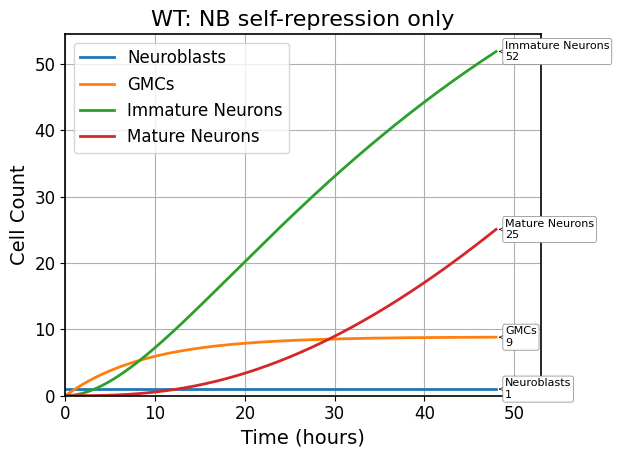

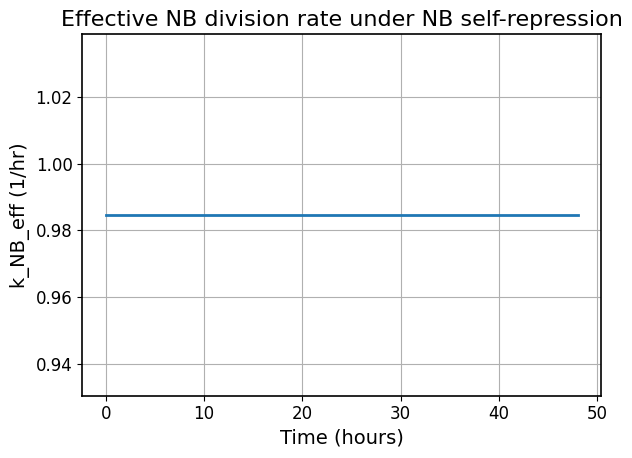

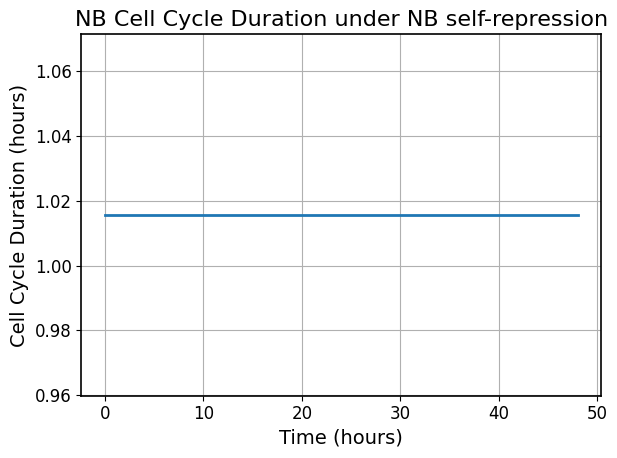

In [19]:
# parameters consistent with earlier choices
k_NB_max   = 1/1      # max NB division rate 1 per hour
k_GMC      = 1/9.0    # avg GMC divides every ~9 h
k_Neuron   = 1/48.0   # avg neuron maturation ~48 h
K_NB_self  = 2.0      # half-max NB count for self-repression
n_self     = 6        # switch-like repression (set to 1 for MM dynamics)
sym_frac   = 0.0      # WT: asymmetric

params = [k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac]

# Initial condition and integration grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_NB_self_repression_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# ---- Plot cell counts ----
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if your helper exists
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT: NB self-repression only")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ---- visualize k_NB_eff over time ----
N_NB = sol.y[0]
if K_NB_self > 0:
    k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + N_NB**n_self)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_NB)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

# ---- visualize NB cell cycle duration over time ----
# Avoid division by zero
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

Without worrying too much about how this shows a higher number of cells than expected, lets see what the same parameters do in a mudmut simulation

### mudmut simulation

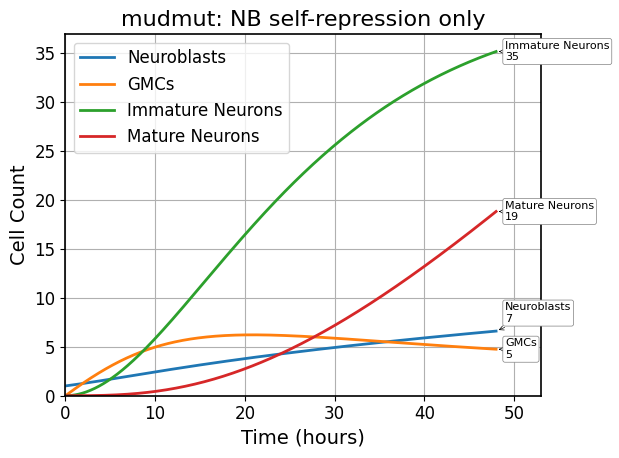

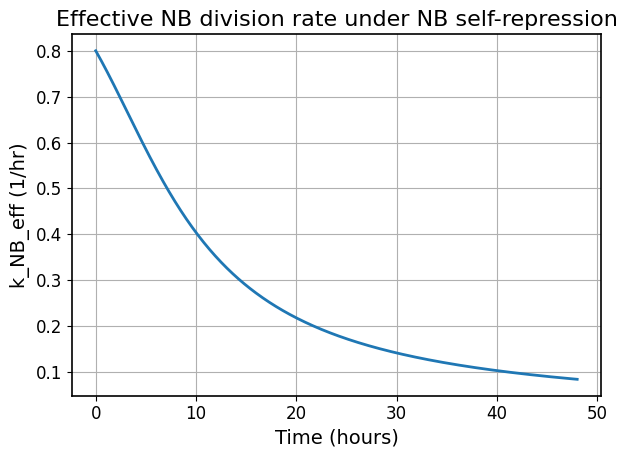

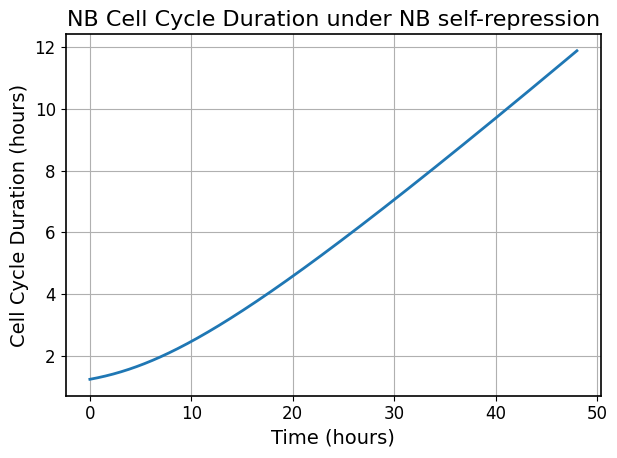

In [20]:
# parameters consistent with earlier choices
k_NB_max   = 1/1      # max NB division rate 1 per hour
k_GMC      = 1/9.0    # avg GMC divides every ~9 h
k_Neuron   = 1/48.0   # avg neuron maturation ~48 h
K_NB_self  = 2.0      # half-max NB count for self-repression
n_self     = 2        # switch-like repression (set to 1 for MM dynamics)
sym_frac   = 0.15     # mudmut: 15% symmetric

params = [k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac]

# Initial condition and integration grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_NB_self_repression_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# ---- Plot cell counts ----
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if your helper exists
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut: NB self-repression only")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ---- visualize k_NB_eff over time ----
N_NB = sol.y[0]
if K_NB_self > 0:
    k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + N_NB**n_self)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_NB)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

# ---- visualize NB cell cycle duration over time ----
# Avoid division by zero
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

**Conclusion:** The NB self-repression regulation is sufficient to drive a significant difference between the WT and mudmut model outputs.

---

## 7. Modeling Volume-Dependent Division

This model tracks both the number and total volume of each cell type in the developing neuroblast lineage. Division rates are **volume-dependent**, modeling a scenerio in which a cell will only divide if it has grown to a sufficient volume.

### Model Species
- **$N_{\text{NB}}$, $V_{\text{NB}}$** — Number and total volume of neuroblasts. Neuroblasts are stem-like cells that grow, and divide either symmetrically (producing two neuroblasts) or asymmetrically (producing one neuroblast and one GMC).
- **$N_{\text{GMC}}$, $V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells (GMCs), which grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}}$, $V_{\text{ImNeuron}}$** — Number and total volume of immature neurons. These do not grow or divide, but they mature into mature neurons.
- **$N_{\text{MatNeuron}}$, $V_{\text{MatNeuron}}$** — Number and total volume of mature neurons, which do not grow, divide, or change state.

### Model Parameters
- **$g_{\text{NB}}$, $g_{\text{GMC}}$** — Growth rates (volume/hour) of neuroblasts and GMCs
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour)
- **$V_{\text{thresh\_NB}}$, $V_{\text{thresh\_GMC}}$** — Volume thresholds that control when neuroblasts and GMCs divide. Note these thresholds are CONSTANT. WT and mudmut NBs divide at the same value
- **$k_{\text{max\_NB}}$, $k_{\text{max\_GMC}}$** — Maximum possible division rates (divisions/hour) for neuroblasts and GMCs
- **$n$** — Hill coefficient controlling sharpness of the threshold response for division
- **$\text{sym\_frac}$** — Fraction of neuroblast divisions that are symmetric (unitless). Set to 0 for WT simulations and 0.15 for *mud* mutant simulations.

### Model Structure

GMC and Neuroblast division rates are volume-dependent via Hill-like sigmoid functions:
$$
k_{\text{NB}} = k_{\text{max\_NB}} \cdot \frac{(V_{\text{avg,NB}})^n}{(V_{\text{thresh\_NB}})^n + (V_{\text{avg,NB}})^n}
$$
$$
k_{\text{GMC}} = k_{\text{max\_GMC}} \cdot \frac{(V_{\text{avg,GMC}})^n}{(V_{\text{thresh\_GMC}})^n + (V_{\text{avg,GMC}})^n}
$$

Total volumes are updated based on growth and loss during division. For example:
- Neuroblast volume increases due to growth and redistributes during division
  - The NB compartment retains .8 * the average NB volume * the number of asymmetric divisions
- GMC volume increases due to growth, and contributes to neuron volume during division
  - the GMC compartment gets .2 * the average NB volume * the number of asymmetric divisions
- Immature neuron volume decreases as neurons mature into mature neurons

In [21]:
def neuroblast_model_volume_threshold_division(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y
    g_NB, g_GMC, k_Neuron, sym_frac, V_thresh_NB, V_thresh_GMC, k_max_NB, k_max_GMC, n = params

    # Avoid divide-by-zero
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    # Volume-dependent division rates
    k_NB = k_max_NB * (Vavg_NB ** n) / (V_thresh_NB ** n + Vavg_NB ** n)
    k_GMC = k_max_GMC * (Vavg_GMC ** n) / (V_thresh_GMC ** n + Vavg_GMC ** n)

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neurons (produced by GMC division, mature at rate k_Neuron)
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neurons (accumulate from maturing immature neurons)
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

### WT Simulation

**Parameter Justifications**
- Initial Neuroblast Volume (`nb_vol = 285` µm³)
  - Based on volumetric measurements from segmented microscopy data of wild-type neuroblasts. Average WT NB volume from `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx`.
- Neuroblast Growth Rate (`g_NB = (nb_vol × 0.2) / 1.5`)
  - Imposed to ensure neuroblasts grow by 20% over 1.5 hours.
- GMC Growth Rate (`g_GMC = (nb_vol × 0.6) / 9`)
  - Reflects GMCs starting at ~0.6× NB volume and growing to 1.2× NB volume over 9 hours, consistent with their expected doubling behavior before division.
- Neuroblast Division Threshold Volume (`V_thresh_NB = nb_vol × 1.2`)
  - Neuroblasts divide once they grow to 1.2× their initial volume.
- GMC Division Threshold Volume (`V_thresh_GMC = (V_thresh_NB × 0.2) × 2`)
  - GMCs are initialized at 20% of the neuroblast’s division volume and divide once they double in size.
- Maximum NB Division Rate (`k_max_NB = 1 / 0.25 hr⁻¹`)
  - Allows a maximum of one NB division every 15 minutes. This is intentionally faster than the average rate (~1 division per 1.5 hours) to allow for volume-dependent modulation via the Hill function. I calibrated this value to achieve approximately the expected number of cells by 48 hours, but we may need to refine. I kept the fraction of the average division rate consistent between the two growth rate maxima (both are 1/6 the average growth rate).
- Maximum GMC Division Rate (`k_max_GMC = 1 / 1.5` hr⁻¹)
  - Allows a maximum of one GMC division every 1.5 hours. As above, this is faster than the literature average (8–9 hours) to allow for volume-dependent control. I kept the fraction of the average division rate consistent between the two growth rate maxima (both are 1/6 the average growth rate).
- Hill Coefficient (`n = 6`)
  - Controls the steepness of the sigmoidal volume-to-division-rate transition. A value of 6 produces a sharp switch-like response near the threshold volume.
- Symmetric Division Fraction (`sym_frac = 0.0`)
  - Set to 0% to reflect wild-type neuroblast behavior, which divides asymmetrically.
- Neuron Maturation Rate (`k_Neuron = 1 / 48` hr⁻¹)
  - Carried over from previous models.

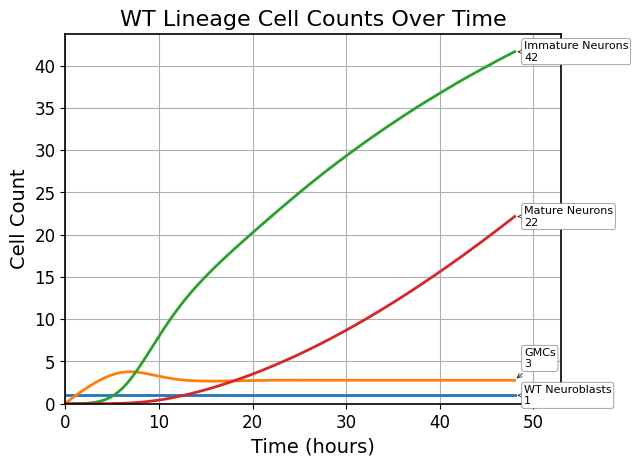

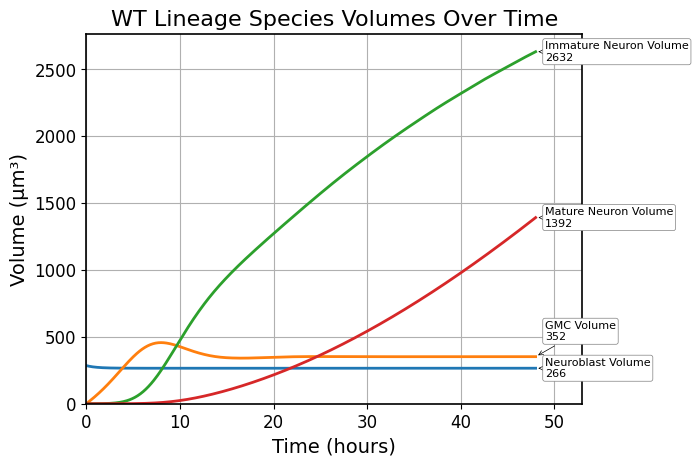

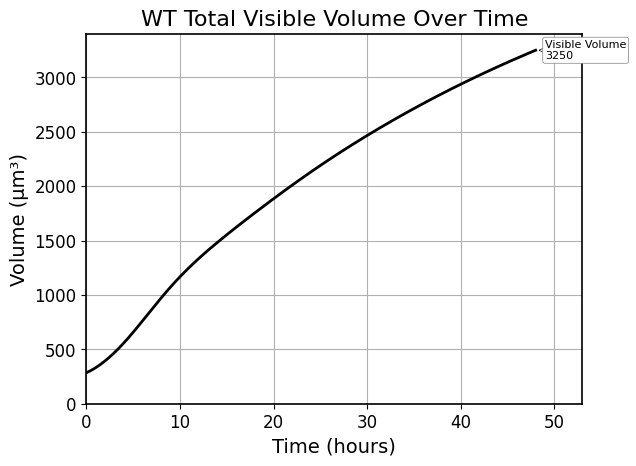

In [22]:
# WT Model of Volume-dependent division

# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_NB = (nb_vol * 0.2 / 1.5)       # NB grows 20% in 1.5 hours
g_GMC = ((nb_vol * 0.6) / 9)      # GMC grows from 0.6 * nb_volume to 1.2 * nb_vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * .2) * 2

k_max_NB = 1 / .25           # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5          # Max GMC division rate (1 per 1.5 hrs)
n = 6                        # Hill coefficient
sym_frac = 0.0               # 0% symmetric divisions
k_Neuron = 1 / 48            # Immature neurons mature in ~48 hrs

params = [
    g_NB,              # NB growth
    g_GMC,             # GMC growth
    k_Neuron,          # Neuron maturation rate
    sym_frac,          # Symmetric division fraction
    V_thresh_NB,       # NB threshold
    V_thresh_GMC,      # GMC threshold
    k_max_NB,          # NB max division rate
    k_max_GMC,         # GMC max division rate
    n                  # Hill coefficient
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

### mudmut model

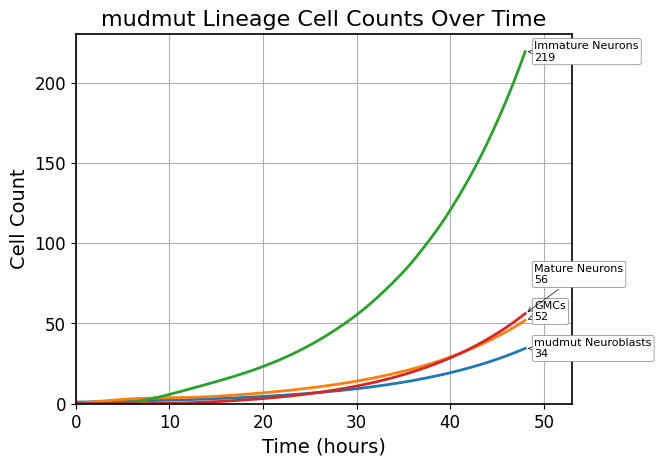

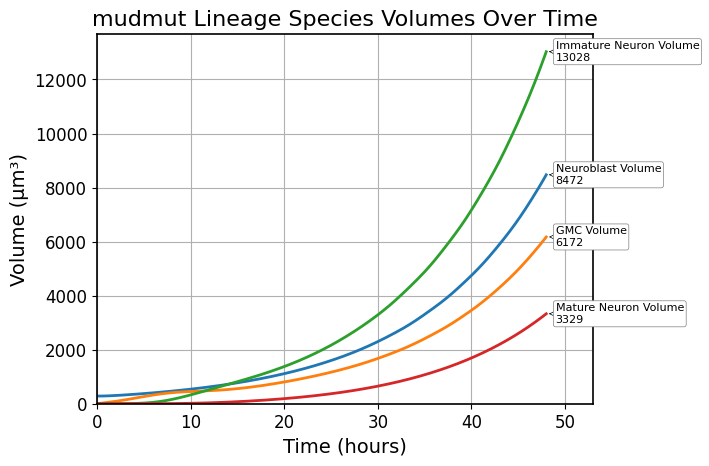

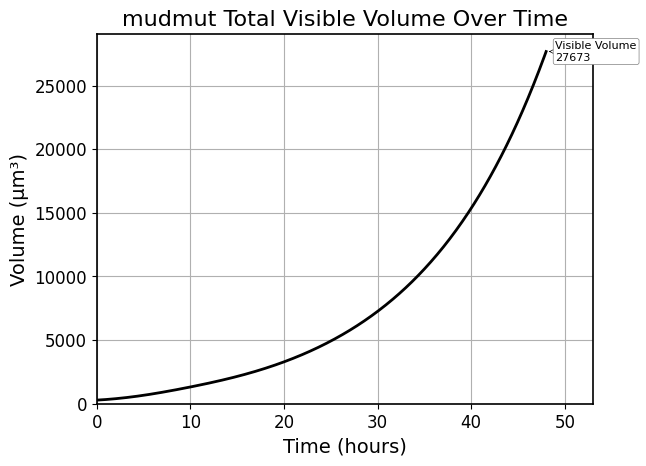

In [23]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_NB = (nb_vol * 0.2 / 1.5)       # NB grows 20% in 1.5 hours
g_GMC = ((nb_vol * 0.6) / 9)      # GMC grows from 0.6 * nb_volume to 1.2 * nb_vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * .2) * 2

k_max_NB = 1 / .25           # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5          # Max GMC division rate (1 per 1.5 hrs)
n = 6                        # Hill coefficient
sym_frac = 0.15              # 15% symmetric divisions
k_Neuron = 1 / 48            # Immature neurons mature in ~48 hrs

params = [
    g_NB,              # NB growth
    g_GMC,             # GMC growth
    k_Neuron,          # Neuron maturation rate
    sym_frac,          # Symmetric division fraction
    V_thresh_NB,       # NB threshold
    V_thresh_GMC,      # GMC threshold
    k_max_NB,          # NB max division rate
    k_max_GMC,         # GMC max division rate
    n                  # Hill coefficient
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

---

## 8. Modeling Volume-Dependent Division (Instantaneous NB Threshold)

This variant tracks the number and total volume of each cell type as before, but sets the **NB division threshold to scale instantly with NB size**:

$$
V_{\text{thresh,NB}}(t)=1.2\,V_{\text{avg,NB}}(t),\qquad
V_{\text{avg,NB}}(t)=\frac{V_{\text{NB}}(t)}{N_{\text{NB}}(t)}.
$$

### Species
- **$N_{\text{NB}}, V_{\text{NB}}$** — Neuroblasts (NBs): grow and divide; divisions can be symmetric (NB+NB) or asymmetric (NB+GMC).
- **$N_{\text{GMC}}, V_{\text{GMC}}$** — Ganglion Mother Cells (GMCs): grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}}, V_{\text{ImNeuron}}$** — Immature neurons: do not grow or divide; mature into mature neurons.
- **$N_{\text{MatNeuron}}, V_{\text{MatNeuron}}$** — Mature neurons: terminal.

### Parameters
- **$g_{\text{NB}}, g_{\text{GMC}}$** — Growth rates (volume/hour).
- **$k_{\text{Neuron}}$** — Maturation rate (transitions/hour).
- **$V_{\text{thresh,GMC}}$** — GMC division threshold (constant in this variant).
- **$k_{\max,\text{NB}}, k_{\max,\text{GMC}}$** — Max division rates (divisions/hour).
- **$n$** — Hill coefficient controlling threshold sharpness.
- **$\text{sym\_frac}$** — Fraction of NB divisions that are symmetric (0 for WT, 0.15 for *mud*).

### Division-Rate Structure

NB and GMC division rates follow Hill-like sigmoids:
$$
k_{\text{NB}}(t)
= k_{\max,\text{NB}}\,
\frac{\big(V_{\text{avg,NB}}(t)\big)^n}
{\big(V_{\text{thresh,NB}}(t)\big)^n+\big(V_{\text{avg,NB}}(t)\big)^n},
\qquad
k_{\text{GMC}}(t)
= k_{\max,\text{GMC}}\,
\frac{\big(V_{\text{avg,GMC}}(t)\big)^n}
{\big(V_{\text{thresh,GMC}}\big)^n+\big(V_{\text{avg,GMC}}(t)\big)^n}.
$$

With the **instantaneous NB threshold** $V_{\text{thresh,NB}}(t)=1.2\,V_{\text{avg,NB}}(t)$ and $N_{\text{NB}}>0$,
$$
k_{\text{NB}}(t)
= k_{\max,\text{NB}}\,
\frac{V^n}{(1.2V)^n+V^n}
= \frac{k_{\max,\text{NB}}}{1+1.2^n}\,,
$$
so **$k_{\text{NB}}$ becomes a constant fraction of $k_{\max,\text{NB}}$** (it no longer varies with NB size).

For my current choices $n=6$ and $k_{\max,\text{NB}}=1/0.25=4\,\text{hr}^{-1}$:
$$
1.2^6\approx 2.99 \;\Rightarrow\;
\frac{1}{1+1.2^6}\approx 0.251 \;\Rightarrow\;
k_{\text{NB,eff}}\approx 0.251\times 4 \approx 1.00\,\text{hr}^{-1},
$$
so **NBs will divide** at ~1 division/hour (mean cycle $\approx 1$ hr) as long as $N_{\text{NB}}>0$.

> **Interpretation:** Because the threshold scales with the current mean NB size, the NB compartment is always at the same *normalized* distance from threshold, eliminating volume-based feedback on NB division rate.

### Volume Updates (unchanged logic)
- NB volume increases via growth and redistributes at division (NB keeps $0.8\times V_{\text{avg,NB}}$ per asymmetric division).
- GMC volume increases via growth; gains $0.2\times V_{\text{avg,NB}}$ per asymmetric NB division; loses volume when dividing.
- Immature neuron volume flows to mature neurons at rate $k_{\text{Neuron}}$.

In [24]:
def neuroblast_model_volume_threshold_division_instant(t, y, params):
    """
    NB threshold is set instantaneously to 1.2x the current average NB volume.
    This makes k_NB a constant fraction of k_max_NB whenever N_NB > 0.
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron) = y

    (g_NB, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_GMC,     # fixed GMC threshold
     k_max_NB, k_max_GMC,
     n) = params

    # --- Average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- NB division rate (constant fraction of k_max_NB) ---
    if N_NB > 0:
        k_NB = k_max_NB / (1.0 + 1.2**n)
    else:
        k_NB = 0.0

    # --- GMC division rate (fixed threshold) ---
    if N_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # --- Divisions ---
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

### WT Model

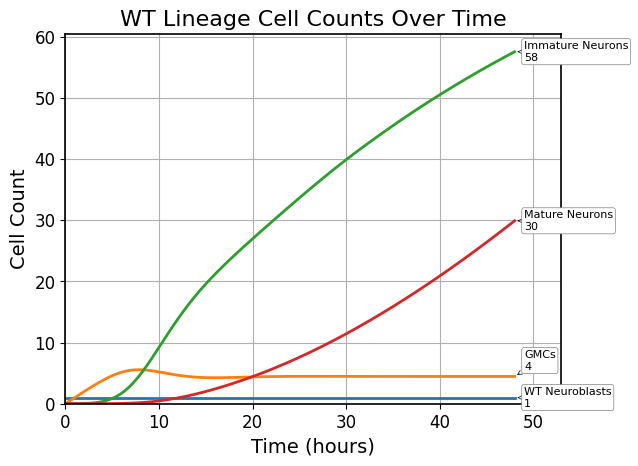

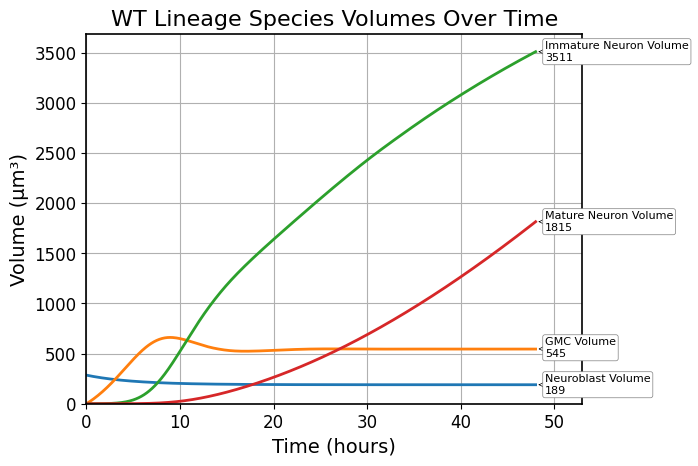

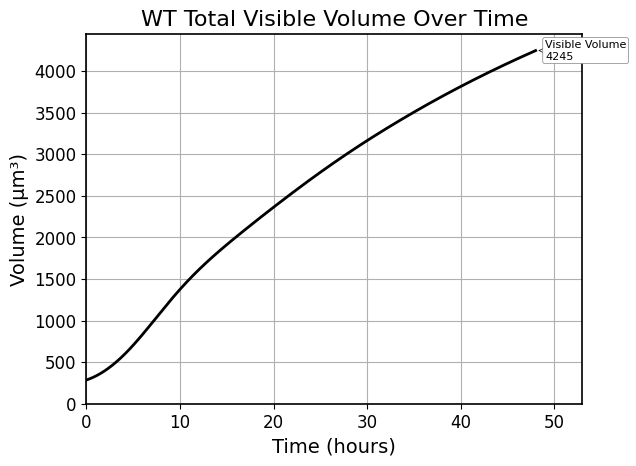

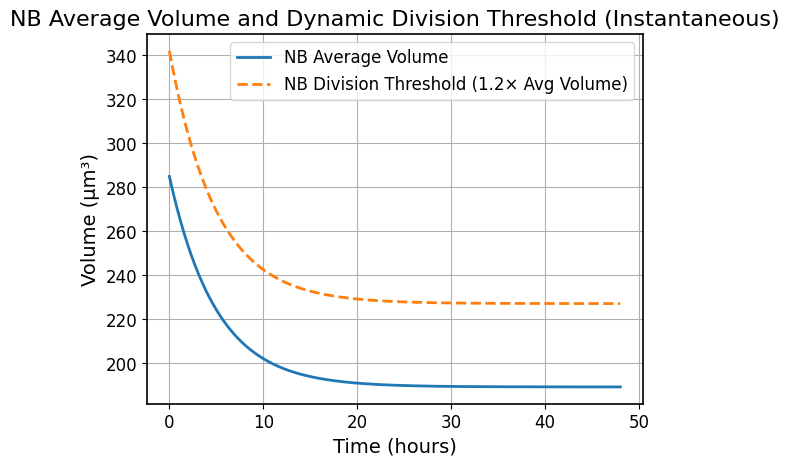

Constant NB division rate: 1.004 per hour
Cell cycle duration: 1.00 hours


In [25]:
# WT
nb_vol = 285
g_NB = nb_vol * 0.2 / 1.5
g_GMC = (nb_vol * 0.6) / 9
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # unchanged for GMC
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.0
k_Neuron = 1 / 48

params_instant = [
    g_NB, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n
]

y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_volume_threshold_division_instant,
    t_span, y0, t_eval=t_eval, args=(params_instant,)
)


# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

# -----------------------------------------------------------------
# Plot NB average volume vs dynamic threshold
Vavg_NB = np.divide(sol.y[1], sol.y[0], out=np.zeros_like(sol.y[1]), where=sol.y[0] > 0)
Vthresh_NB_t = 1.2 * Vavg_NB

fig, ax = plt.subplots()
ax.plot(sol.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol.t, Vthresh_NB_t, '--', label="NB Division Threshold (1.2× Avg Volume)")
ax.set_xlabel("Time (hours)"); ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume and Dynamic Division Threshold (Instantaneous)")
ax.legend(); ax.grid(); plt.show()

# -----------------------------------------------------------------
# Plot constant NB division rate and cell cycle duration
k_NB_eff = k_max_NB / (1 + 1.2**n)
cell_cycle_duration = 1.0 / k_NB_eff

print(f"Constant NB division rate: {k_NB_eff:.3f} per hour")
print(f"Cell cycle duration: {cell_cycle_duration:.2f} hours")

### mudmut model

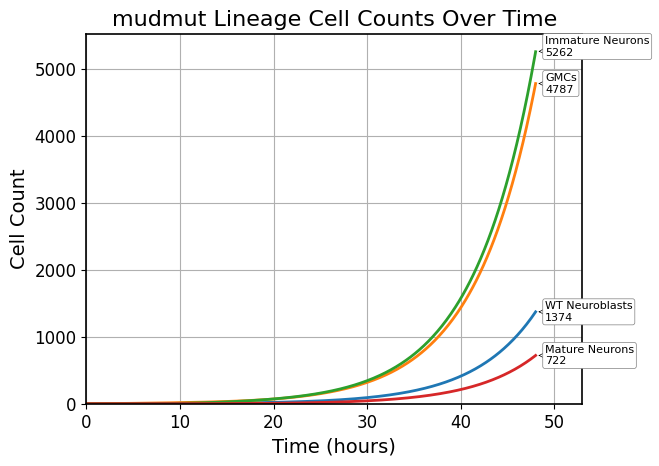

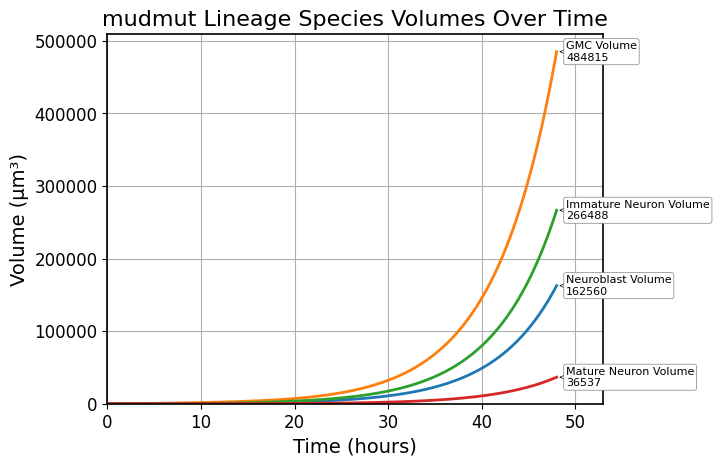

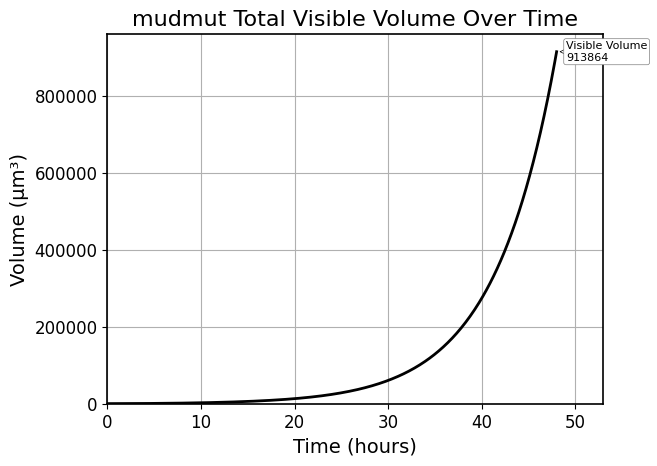

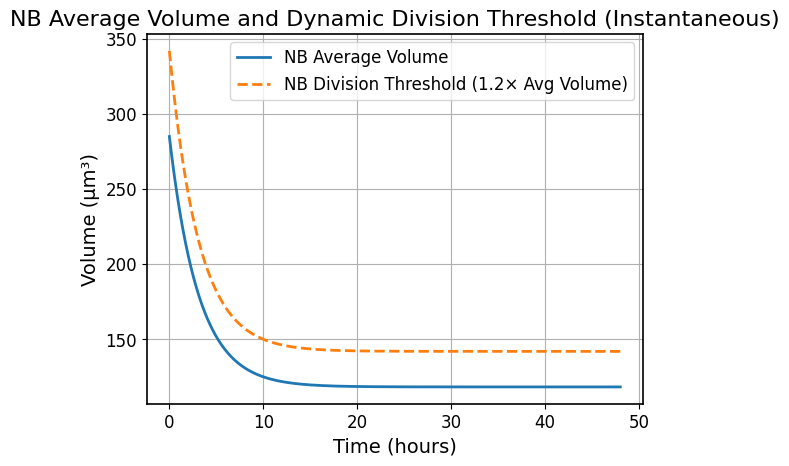

Constant NB division rate: 1.004 per hour
Cell cycle duration: 1.00 hours


In [26]:
# mudmut
nb_vol = 285
g_NB = nb_vol * 0.2 / 1.5
g_GMC = (nb_vol * 0.6) / 9
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # unchanged for GMC
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.15
k_Neuron = 1 / 48

params_instant = [
    g_NB, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n
]

y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_volume_threshold_division_instant,
    t_span, y0, t_eval=t_eval, args=(params_instant,)
)


# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

# -----------------------------------------------------------------
# Plot NB average volume vs dynamic threshold
Vavg_NB = np.divide(sol.y[1], sol.y[0], out=np.zeros_like(sol.y[1]), where=sol.y[0] > 0)
Vthresh_NB_t = 1.2 * Vavg_NB

fig, ax = plt.subplots()
ax.plot(sol.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol.t, Vthresh_NB_t, '--', label="NB Division Threshold (1.2× Avg Volume)")
ax.set_xlabel("Time (hours)"); ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume and Dynamic Division Threshold (Instantaneous)")
ax.legend(); ax.grid(); plt.show()

# -----------------------------------------------------------------
# Plot constant NB division rate and cell cycle duration
k_NB_eff = k_max_NB / (1 + 1.2**n)
cell_cycle_duration = 1.0 / k_NB_eff

print(f"Constant NB division rate: {k_NB_eff:.3f} per hour")
print(f"Cell cycle duration: {cell_cycle_duration:.2f} hours")

### Conclusion:
- Making the division threshold a constant fraction of the average cell volume at any given time makes the division rate no longer sensitive to NB size (instead making it a constant fraction of the specified max division rate). The behavior of this model is essentially equivalent to the cell-count–only model, in which NB division proceeds at a fixed rate whenever NBs are present, regardless of whether they are large or small. In other words, volume no longer regulates when divisions occur.

---

## 9. Modeling Volume-Dependent Division (Lagged/Adaptive NB Threshold)

This variant tracks the same species and volumes as the instantaneous model, but the **NB division threshold changes gradually** in response to the current NB average volume rather than adjusting instantaneously.

The NB division threshold $V_{\text{thresh,NB}}(t)$ relaxes toward $1.2\times V_{\text{avg,NB}}(t)$ with a **time constant** $\tau_{\text{thresh,NB}}$ (in hours):
$$
\frac{d}{dt}V_{\text{thresh,NB}} = \frac{1}{\tau_{\text{thresh,NB}}}
\left( 1.2\,V_{\text{avg,NB}}(t) - V_{\text{thresh,NB}}(t) \right)
$$
where
$$
V_{\text{avg,NB}}(t) = \frac{V_{\text{NB}}(t)}{N_{\text{NB}}(t)}
$$
and $V_{\text{thresh,NB}}(0)$ is initialized close to $1.2\times V_{\text{avg,NB}}(0)$.

### Species
- **$N_{\text{NB}}, V_{\text{NB}}$** — Neuroblasts (NBs): grow and divide; divisions can be symmetric (NB+NB) or asymmetric (NB+GMC).
- **$N_{\text{GMC}}, V_{\text{GMC}}$** — Ganglion Mother Cells (GMCs): grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}}, V_{\text{ImNeuron}}$** — Immature neurons: do not grow or divide; mature into mature neurons.
- **$N_{\text{MatNeuron}}, V_{\text{MatNeuron}}$** — Mature neurons: terminal.
- **$V_{\text{thresh,NB}}$** — Dynamic NB division threshold (new state variable).

### Parameters
- **$g_{\text{NB}}, g_{\text{GMC}}$** — Growth rates (volume/hour).
- **$k_{\text{Neuron}}$** — Maturation rate (transitions/hour).
- **$V_{\text{thresh,GMC}}$** — GMC division threshold (constant in this variant).
- **$k_{\max,\text{NB}}, k_{\max,\text{GMC}}$** — Max division rates (divisions/hour).
- **$n$** — Hill coefficient controlling threshold sharpness.
- **$\text{sym\_frac}$** — Fraction of NB divisions that are symmetric.
- **$\tau_{\text{thresh,NB}}$** — Time constant for NB threshold adjustment (hours).

### Division-Rate Structure
NB and GMC division rates follow Hill-like sigmoids:
$$
k_{\text{NB}}(t)
= k_{\max,\text{NB}}\,
\frac{\big(V_{\text{avg,NB}}(t)\big)^n}
{\big(V_{\text{thresh,NB}}(t)\big)^n+\big(V_{\text{avg,NB}}(t)\big)^n}
$$
$$
k_{\text{GMC}}(t)
= k_{\max,\text{GMC}}\,
\frac{\big(V_{\text{avg,GMC}}(t)\big)^n}
{\big(V_{\text{thresh,GMC}}\big)^n+\big(V_{\text{avg,GMC}}(t)\big)^n}
$$

Because $V_{\text{thresh,NB}}$ **changes gradually**, NB division rate is still sensitive to NB size but with a **delay**. This creates a form of “volume memory”.

### Volume Updates
- NB volume increases via growth and redistributes during division (NB keeps $0.8\times V_{\text{avg,NB}}$ per asymmetric division).
- GMC volume increases via growth; gains $0.2\times V_{\text{avg,NB}}$ per asymmetric NB division; loses volume when dividing.
- Immature neuron volume flows to mature neurons at rate $k_{\text{Neuron}}$.
- NB division threshold drifts toward $1.2\times V_{\text{avg,NB}}$ with time constant $\tau_{\text{thresh,NB}}$.

### Conclusion
- The lagged/adaptive threshold preserves **volume-based regulation** of NB division but filters it over time, reducing sensitivity to rapid, transient volume changes.
- This approach may better reflect biological scenarios where cell cycle regulators integrate volume cues over a finite time before triggering division.

In [27]:
def neuroblast_model_volume_threshold_division_adaptive(t, y, params):
    """
    NB threshold relaxes toward 1.2x the current average NB volume with time constant tau_thresh_NB.
    This preserves volume sensitivity and smooths rapid fluctuations.
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron,
     Vthresh_NB) = y

    (g_NB, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_GMC,      # fixed GMC threshold
     k_max_NB, k_max_GMC,
     n,
     tau_thresh_NB) = params
    
    if t == 0.0:
        assert 0.0 <= sym_frac <= 1.0, f"sym_frac out of range: {sym_frac}"
        print(f"[debug] t=0 sym_frac={sym_frac:.6f}, k_max_NB={k_max_NB}, n={n}, tau={tau_thresh_NB}")

    # --- Average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- Update NB threshold toward 1.2x avg NB volume ---
    target_thresh_NB = 1.2 * Vavg_NB
    dVthresh_NB = (target_thresh_NB - Vthresh_NB) / tau_thresh_NB

    # --- NB division rate ---
    if N_NB > 0 and Vthresh_NB > 0:
        k_NB = k_max_NB * (Vavg_NB**n) / (Vthresh_NB**n + Vavg_NB**n)
    else:
        k_NB = 0.0

    # --- GMC division rate ---
    if N_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # --- Divisions ---
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron,
        dVthresh_NB
    ]

### WT Model

[debug] t=0 sym_frac=0.000000, k_max_NB=4.0, n=6, tau=1.0


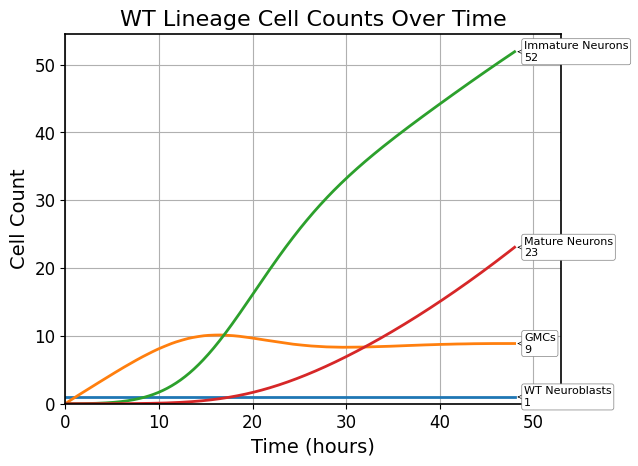

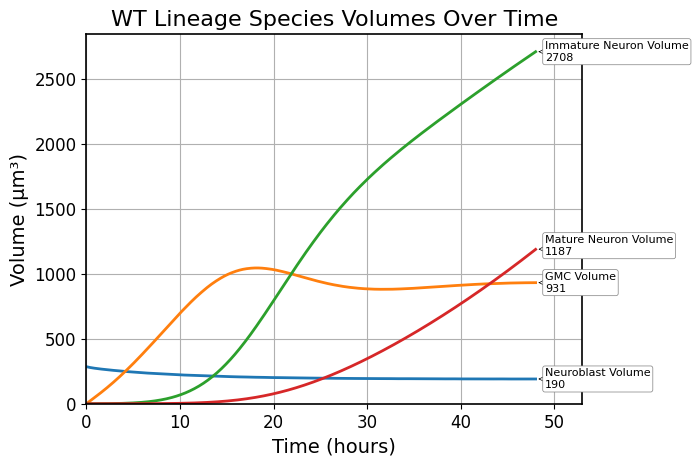

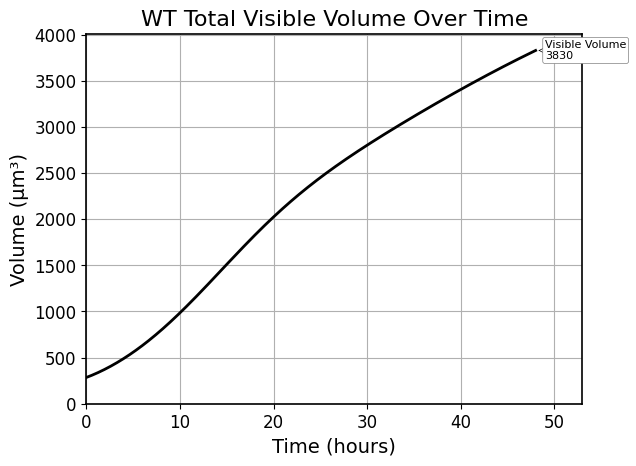

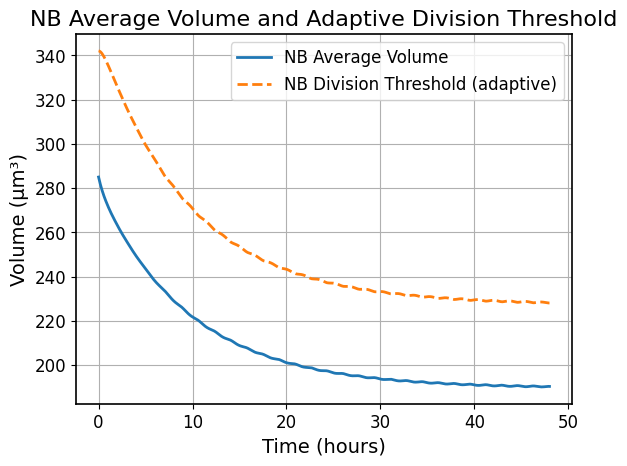

In [28]:

# WT
nb_vol = 285
g_NB = nb_vol * 0.2 / 1.5  # NB grow to 120% their initial size in 90 minutes
g_GMC = (nb_vol * 1.2 * 0.2) / 9 # GMCs add volume equivalent to nb_vol * 1.2 * .2 in 9 hours
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # GMC division threshold volume is twice their initial volume
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.0
k_Neuron = 1 / 48
tau_thresh_NB = 1.0  # hours to adjust threshold

params_adaptive = [
    g_NB, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB
]

# Initial conditions: include Vthresh_NB
Vthresh0 = 1.2 * nb_vol
y0_adaptive = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol_adaptive = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive,
    t_span, y0_adaptive, t_eval=t_eval, args=(params_adaptive,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol_adaptive.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_adaptive.t, y, label=label)

ax.set_xlim(0, sol_adaptive.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_adaptive.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol_adaptive.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_adaptive.t, y, label=label)

ax.set_xlim(0, sol_adaptive.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_adaptive.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol_adaptive.y[1] + sol_adaptive.y[3] + sol_adaptive.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol_adaptive.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_adaptive.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_adaptive.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

# Plot NB avg volume vs adaptive threshold
Vavg_NB = np.divide(sol_adaptive.y[1], sol_adaptive.y[0],
                    out=np.zeros_like(sol_adaptive.y[1]),
                    where=sol_adaptive.y[0] > 0)
Vthresh_NB_t = sol_adaptive.y[8]

fig, ax = plt.subplots()
ax.plot(sol_adaptive.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_adaptive.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.set_xlabel("Time (hours)"); ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume and Adaptive Division Threshold")
ax.legend(); ax.grid(); plt.show()

### Mudmut model

[debug] t=0 sym_frac=0.150000, k_max_NB=4.0, n=6, tau=1.0


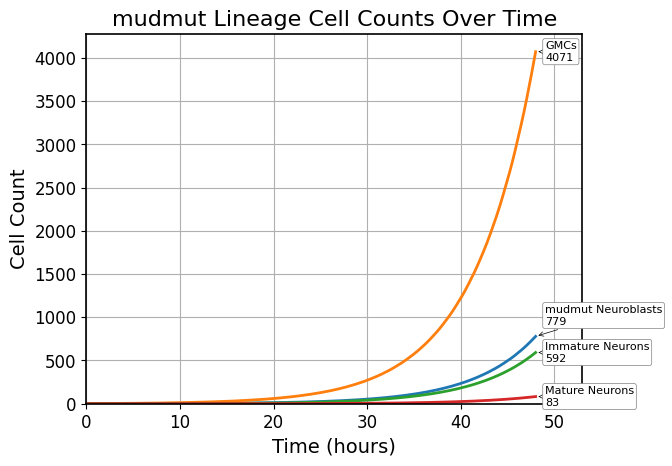

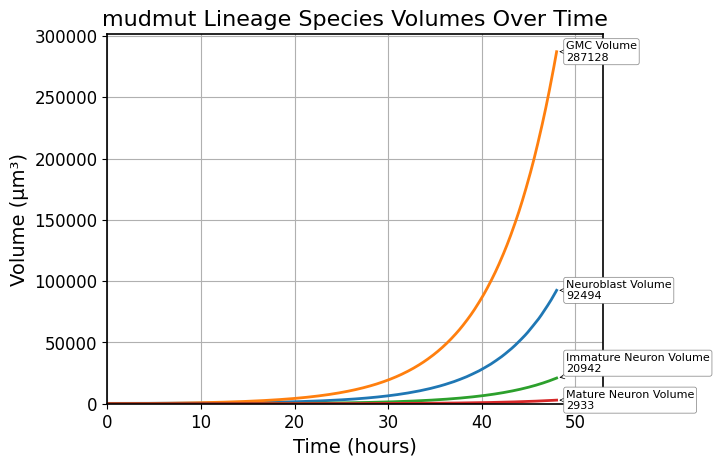

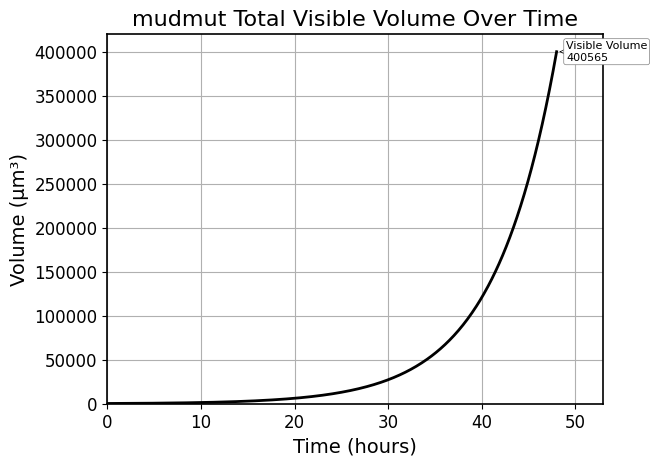

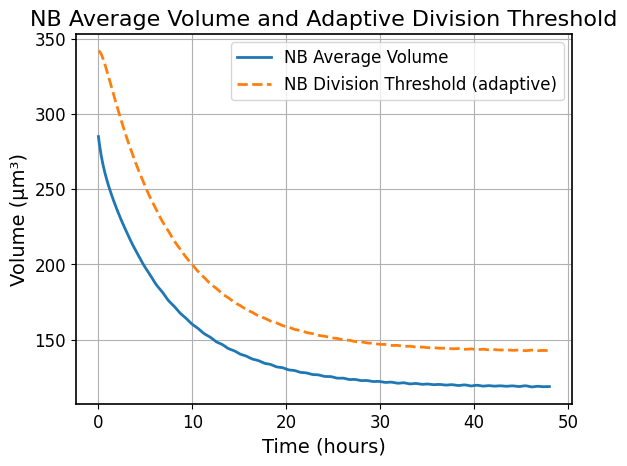

In [29]:

# mudmut
nb_vol = 285
g_NB = nb_vol * 0.2 / 1.5  # NB grow to 120% their initial size in 90 minutes
g_GMC = (nb_vol * 1.2 * 0.2) / 9 # GMCs add volume equivalent to nb_vol * 1.2 * .2 in 9 hours
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # GMC division threshold volume is twice their initial volume
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.15
k_Neuron = 1 / 48
tau_thresh_NB = 1.0  # hours to adjust threshold

params_adaptive = [
    g_NB, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB
]

# Initial conditions: include Vthresh_NB
Vthresh0 = 1.2 * nb_vol
y0_adaptive = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol_adaptive = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive,
    t_span, y0_adaptive, t_eval=t_eval, args=(params_adaptive,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol_adaptive.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_adaptive.t, y, label=label)

ax.set_xlim(0, sol_adaptive.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_adaptive.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol_adaptive.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_adaptive.t, y, label=label)

ax.set_xlim(0, sol_adaptive.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_adaptive.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol_adaptive.y[1] + sol_adaptive.y[3] + sol_adaptive.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol_adaptive.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_adaptive.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_adaptive.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

# Plot NB avg volume vs adaptive threshold
Vavg_NB = np.divide(sol_adaptive.y[1], sol_adaptive.y[0],
                    out=np.zeros_like(sol_adaptive.y[1]),
                    where=sol_adaptive.y[0] > 0)
Vthresh_NB_t = sol_adaptive.y[8]

fig, ax = plt.subplots()
ax.plot(sol_adaptive.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_adaptive.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.set_xlabel("Time (hours)"); ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume and Adaptive Division Threshold")
ax.legend(); ax.grid(); plt.show()

---
# Depending on which of the three above models we "like" most I can add in the NB-NB feedback where NB count suppresses NB Growth. Here I show this with the constant division threshold as proof of concept:

## 10. NB-NB Feedback on Model 7

In [30]:
def neuroblast_model_volume_threshold_division_NBgrowthRepress(t, y, params):
    """
    Volume-threshold division model where NB growth is negatively regulated by NB count
    using a decreasing Hill function.

    g_NB_eff = g_NB_base * K^m / (K^m + N_NB^m)

    Parameter order:
      g_NB_base, g_GMC, k_Neuron, sym_frac,
      V_thresh_NB, V_thresh_GMC,
      k_max_NB, k_max_GMC, n,
      K_NB_growth, m_growth
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron) = y

    (g_NB_base, g_GMC, k_Neuron, sym_frac,
     V_thresh_NB, V_thresh_GMC,
     k_max_NB, k_max_GMC, n,
     K_NB_growth, m_growth) = params

    # --- Safe average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- Volume-dependent division rates (unchanged) ---
    k_NB = k_max_NB * (Vavg_NB**n) / (V_thresh_NB**n + Vavg_NB**n) if N_NB > 0 else 0.0
    k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n) if N_GMC > 0 else 0.0

    # --- NB growth repression by NB count (decreasing Hill) ---
    if N_NB > 0 and K_NB_growth > 0:
        growth_repress = (K_NB_growth**m_growth) / (K_NB_growth**m_growth + N_NB**m_growth)
    else:
        growth_repress = 1.0
    g_NB_eff = g_NB_base * growth_repress

    # --- Divisions ---
    sym_divs  = sym_frac * k_NB * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB_eff * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

### WT

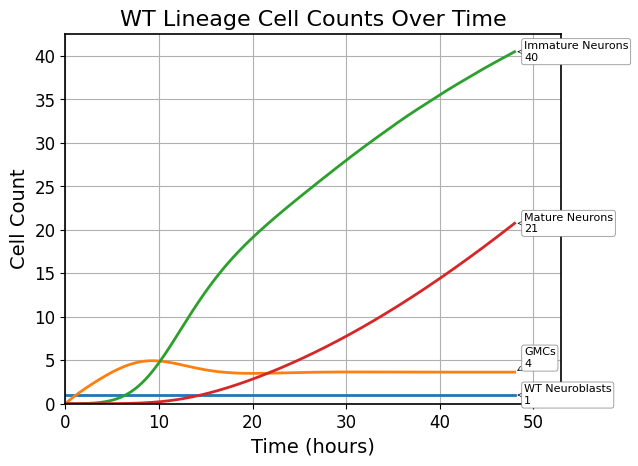

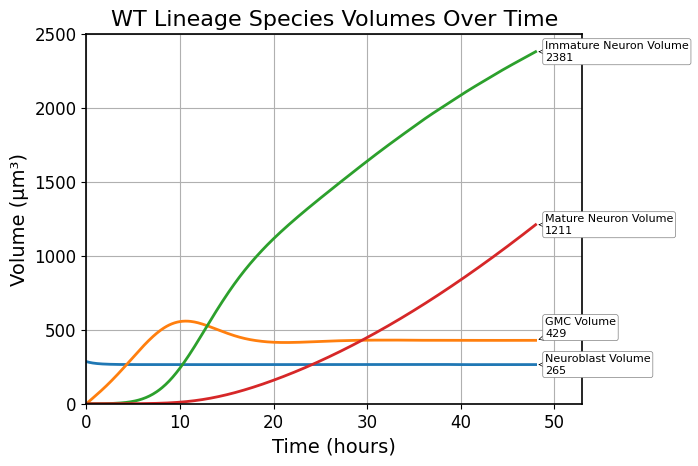

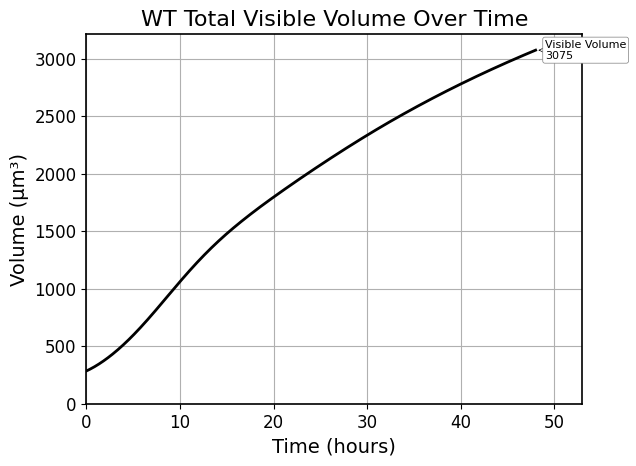

In [31]:
# WT
nb_vol = 285
g_NB_base = nb_vol * 0.2 / 1.5
g_GMC = (nb_vol * 0.4) / 9
V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.0
k_Neuron = 1 / 48

# Growth repression settings
K_NB_growth = 2.0  # NB count for half-max growth
m_growth = 6.0     # steepness

params = [
    g_NB_base, g_GMC, k_Neuron, sym_frac,
    V_thresh_NB, V_thresh_GMC,
    k_max_NB, k_max_GMC, n,
    K_NB_growth, m_growth
]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_volume_threshold_division_NBgrowthRepress,
    t_span, y0, t_eval=t_eval, args=(params,)
)
# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()


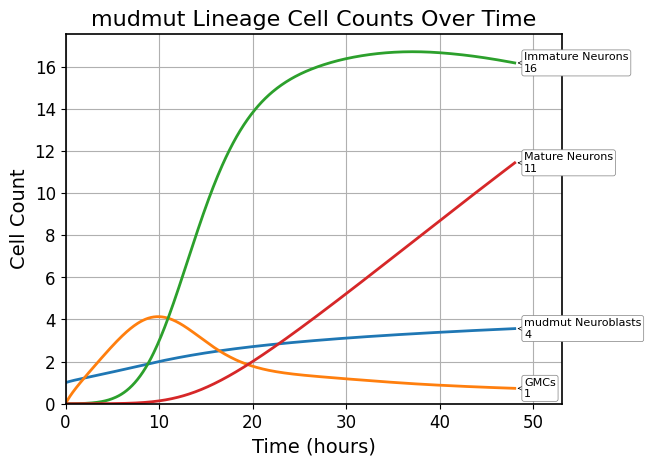

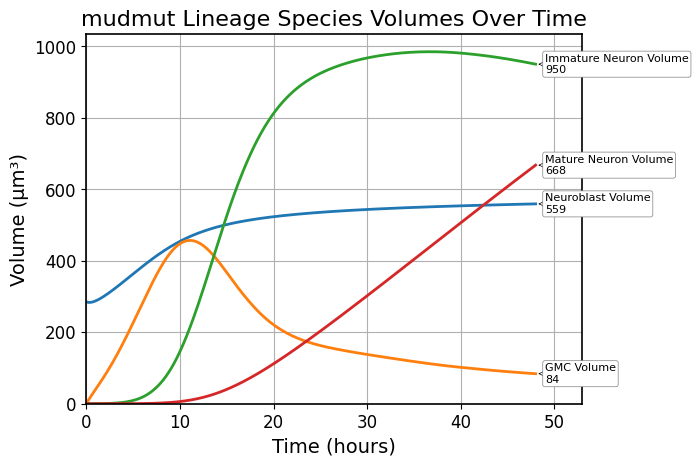

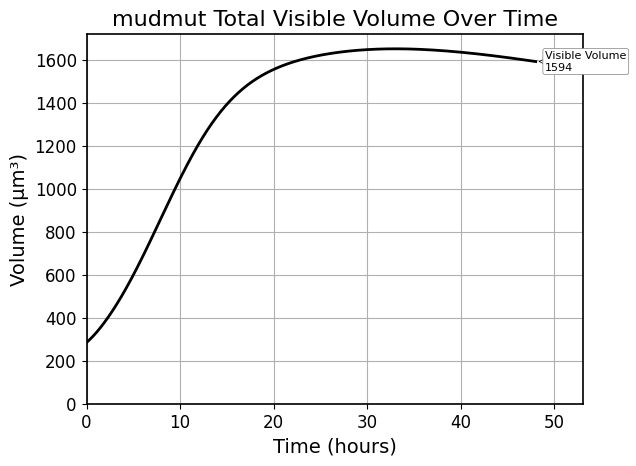

In [32]:
# mudmut
nb_vol = 285
g_NB_base = nb_vol * 0.2 / 1.5
g_GMC = (nb_vol * 0.4) / 9
V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.15
k_Neuron = 1 / 48

# Growth repression settings
K_NB_growth = 2.0  # NB count for half-max growth
m_growth = 6.0     # steepness

params = [
    g_NB_base, g_GMC, k_Neuron, sym_frac,
    V_thresh_NB, V_thresh_GMC,
    k_max_NB, k_max_GMC, n,
    K_NB_growth, m_growth
]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_volume_threshold_division_NBgrowthRepress,
    t_span, y0, t_eval=t_eval, args=(params,)
)
# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()


# Here I show feedback with Lagged/Adaptive NB Division Threshold Model. Interestingly allowing the division threshold to decrease with the average NB size eliminates the NB count feedback's ability to regulate mudmut colony size:

## 11. NB-NB Feedback on Model 9

In [33]:
def neuroblast_model_volume_threshold_division_adaptive_growRepress(t, y, params):
    """
    Adaptive NB threshold + NB-growth repression by NB count (decreasing Hill).
    Vthresh_NB relaxes toward 1.2 * Vavg_NB with time constant tau_thresh_NB.
    NB growth rate becomes: g_NB_eff = g_NB_base * K^m / (K^m + N_NB^m).
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron,
     Vthresh_NB) = y

    (g_NB_base, g_GMC,           # <-- g_NB is now 'base' (pre-repression)
     k_Neuron,
     sym_frac,
     V_thresh_GMC,               # fixed GMC threshold
     k_max_NB, k_max_GMC,
     n,                          # Hill for division
     tau_thresh_NB,              # time constant for NB threshold adaptation (hours)
     K_NB_growth, m_growth) = params   # growth-repression Hill params

    # Debug at t=0 (optional)
    if t == 0.0:
        assert 0.0 <= sym_frac <= 1.0, f"sym_frac out of range: {sym_frac}"
        # print(f"[debug] t=0 sym_frac={sym_frac:.6f}, K_g={K_NB_growth}, m={m_growth}")

    # --- Average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- Adaptive NB threshold toward 1.2x avg NB volume ---
    target_thresh_NB = 1.2 * Vavg_NB
    dVthresh_NB = (target_thresh_NB - Vthresh_NB) / tau_thresh_NB

    # --- NB division rate (volume-threshold Hill) ---
    if N_NB > 0 and Vthresh_NB > 0:
        k_NB = k_max_NB * (Vavg_NB**n) / (Vthresh_NB**n + Vavg_NB**n)
    else:
        k_NB = 0.0

    # --- GMC division rate (unchanged) ---
    if N_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # --- NB growth repression by NB count (decreasing Hill) ---
    if N_NB > 0 and K_NB_growth > 0:
        growth_repress = (K_NB_growth**m_growth) / (K_NB_growth**m_growth + N_NB**m_growth)
    else:
        growth_repress = 1.0
    g_NB_eff = g_NB_base * growth_repress

    # --- Divisions ---
    sym_frac_eff = float(np.clip(sym_frac, 0.0, 1.0))
    sym_divs  = 0.0 if sym_frac_eff <= 1e-12 else sym_frac_eff * k_NB * N_NB
    asym_divs = (1.0 - sym_frac_eff) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB_eff * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron,
        dVthresh_NB
    ]

### WT

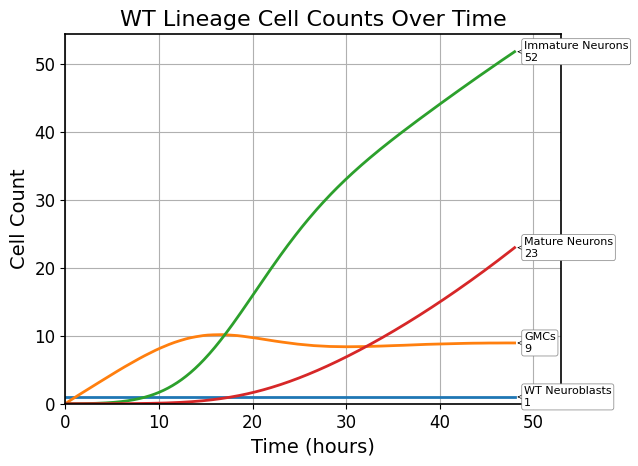

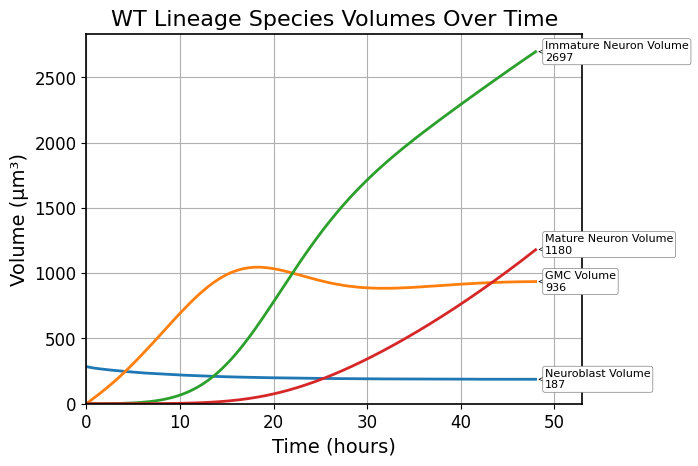

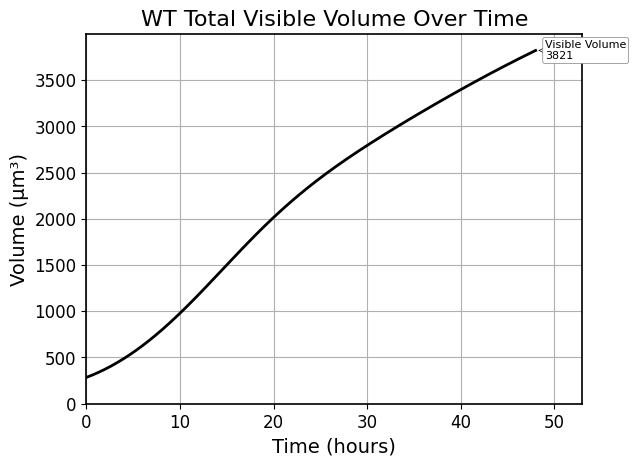

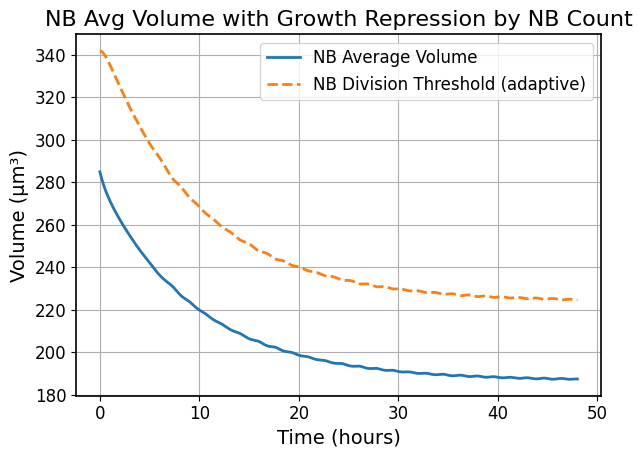

In [34]:
nb_vol = 285
g_NB_base = nb_vol * 0.2 / 1.5  # NB grow to 120% their initial size in 90 minutes
g_GMC = (nb_vol * 1.2 * 0.2) / 9 # GMCs add volume equivalent to nb_vol * 1.2 * .2 in 9 hours
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # GMC division threshold volume is twice their initial volume
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.0
k_Neuron = 1 / 48
tau_thresh_NB = 1.0  # hours to adjust threshold
K_NB_growth = 2.0           # NB count at half-max NB growth
m_growth = 6.0              # Hill for growth repression

params_growthRepress = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    K_NB_growth, m_growth
]

# Initial conditions (include Vthresh_NB state)
Vthresh0 = 1.2 * nb_vol
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol_growthRepress = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_growRepress,
    t_span, y0, t_eval=t_eval, args=(params_growthRepress,)
)


# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol_growthRepress.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_growthRepress.t, y, label=label)

ax.set_xlim(0, sol_growthRepress.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_growthRepress.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol_growthRepress.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_growthRepress.t, y, label=label)

ax.set_xlim(0, sol_growthRepress.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_growthRepress.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol_growthRepress.y[1] + sol_growthRepress.y[3] + sol_growthRepress.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol_growthRepress.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_growthRepress.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_growthRepress.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

# Plot NB average volume and adaptive threshold ---
Vavg_NB = np.divide(sol_growthRepress.y[1], sol_growthRepress.y[0],
                    out=np.zeros_like(sol_growthRepress.y[1]),
                    where=sol_growthRepress.y[0] > 0)
Vthresh_NB_t = sol_growthRepress.y[8]

fig, ax = plt.subplots()
ax.plot(sol_growthRepress.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_growthRepress.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.set_xlabel("Time (hours)"); ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Avg Volume with Growth Repression by NB Count")
ax.grid(); ax.legend(); plt.tight_layout(); plt.show()

### mudmut

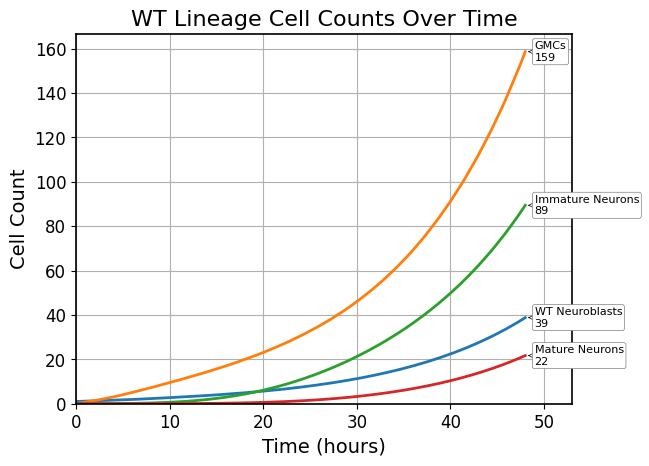

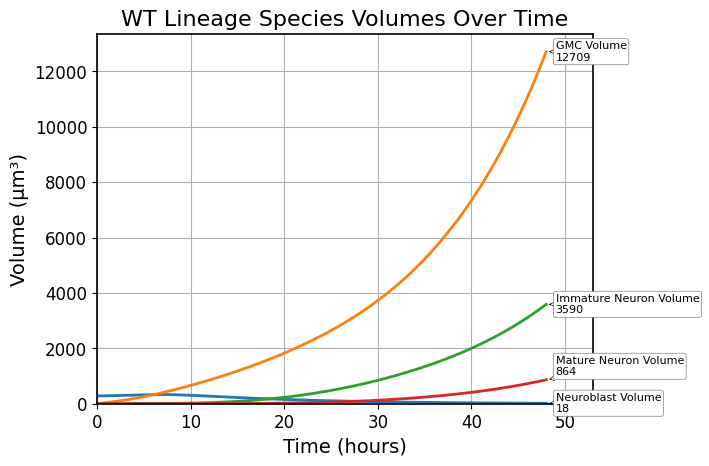

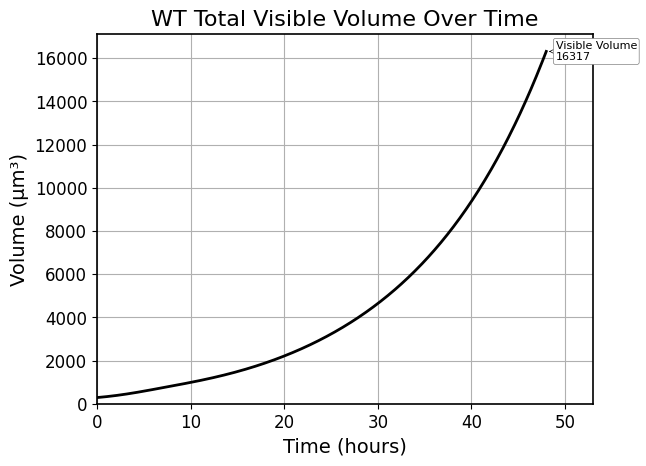

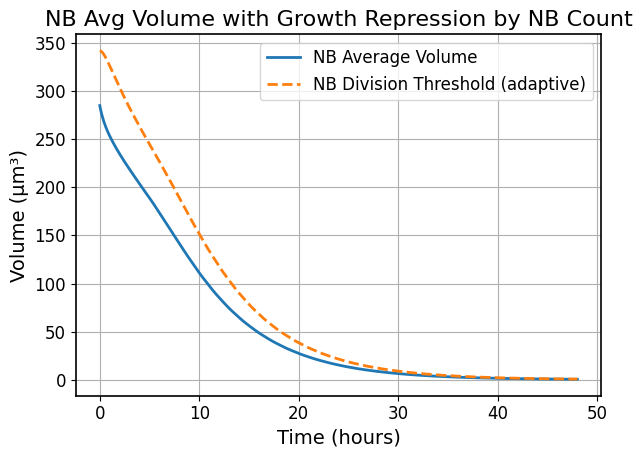

In [35]:
nb_vol = 285
g_NB_base = nb_vol * 0.2 / 1.5  # NB grow to 120% their initial size in 90 minutes
g_GMC = (nb_vol * 1.2 * 0.2) / 9 # GMCs add volume equivalent to nb_vol * 1.2 * .2 in 9 hours
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # GMC division threshold volume is twice their initial volume
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.15
k_Neuron = 1 / 48
tau_thresh_NB = 1.0  # hours to adjust threshold
K_NB_growth = 2.0           # NB count at half-max NB growth
m_growth = 6.0              # Hill for growth repression

params_growthRepress = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    K_NB_growth, m_growth
]

# Initial conditions (include Vthresh_NB state)
Vthresh0 = 1.2 * nb_vol
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol_growthRepress = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_growRepress,
    t_span, y0, t_eval=t_eval, args=(params_growthRepress,)
)


# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol_growthRepress.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_growthRepress.t, y, label=label)

ax.set_xlim(0, sol_growthRepress.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_growthRepress.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol_growthRepress.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_growthRepress.t, y, label=label)

ax.set_xlim(0, sol_growthRepress.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_growthRepress.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol_growthRepress.y[1] + sol_growthRepress.y[3] + sol_growthRepress.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol_growthRepress.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_growthRepress.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol_growthRepress.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

# Plot NB average volume and adaptive threshold ---
Vavg_NB = np.divide(sol_growthRepress.y[1], sol_growthRepress.y[0],
                    out=np.zeros_like(sol_growthRepress.y[1]),
                    where=sol_growthRepress.y[0] > 0)
Vthresh_NB_t = sol_growthRepress.y[8]

fig, ax = plt.subplots()
ax.plot(sol_growthRepress.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_growthRepress.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.set_xlabel("Time (hours)"); ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Avg Volume with Growth Repression by NB Count")
ax.grid(); ax.legend(); plt.tight_layout(); plt.show()

## 12. Modeling Volume-Dependent Division with Adaptive Threshold and Minimum Volume Requirement

This model tracks both the number and total volume of each cell type in the developing neuroblast (NB) lineage, similar to the adaptive-threshold model, but adds a **minimum volume requirement** for NB division.

### Key Features
- **Adaptive NB Threshold:**
  The NB division threshold $V_{\text{thresh,NB}}(t)$ relaxes toward $1.2\times V_{\text{avg,NB}}(t)$ with a user-specified time constant $\tau_{\text{thresh,NB}}$.
  $$
  \frac{d}{dt}V_{\text{thresh,NB}} = \frac{1}{\tau_{\text{thresh,NB}}}
  \left( 1.2\,V_{\text{avg,NB}}(t) - V_{\text{thresh,NB}}(t) \right)
  $$
- **Volume Floor for Division:**
  Neuroblasts can only divide if their **average volume** exceeds a fixed floor value $V_{\text{floor,NB}}$. If $V_{\text{avg,NB}} < V_{\text{floor,NB}}$, the NB division rate is set to 0.

### Species
- $N_{\text{NB}}, V_{\text{NB}}$ — Neuroblasts: grow and divide, producing NBs or GMCs.
- $N_{\text{GMC}}, V_{\text{GMC}}$ — Ganglion Mother Cells: grow and divide into immature neurons.
- $N_{\text{ImNeuron}}, V_{\text{ImNeuron}}$ — Immature neurons: mature into mature neurons.
- $N_{\text{MatNeuron}}, V_{\text{MatNeuron}}$ — Mature neurons: terminal state.
- $V_{\text{thresh,NB}}$ — Dynamic NB division threshold (state variable).

### Parameters
- $g_{\text{NB}}, g_{\text{GMC}}$ — Growth rates (volume/hour).
- $k_{\text{Neuron}}$ — Maturation rate for immature neurons.
- $V_{\text{thresh,GMC}}$ — Fixed GMC division threshold.
- $k_{\max,\text{NB}}, k_{\max,\text{GMC}}$ — Max division rates.
- $n$ — Hill coefficient for division threshold sharpness.
- $\text{sym\_frac}$ — Fraction of NB divisions that are symmetric.
- $\tau_{\text{thresh,NB}}$ — Time constant for NB threshold adaptation.
- $V_{\text{floor,NB}}$ — **Minimum average NB volume required to divide**.

### Division Rate Formulation
- **NB Division Rate** (only if $V_{\text{avg,NB}} \ge V_{\text{floor,NB}}$, otherwise set to 0):
  $$
  k_{\text{NB}}(t) =
  k_{\max,\text{NB}} \cdot \frac{V_{\text{avg,NB}}(t)^n}{V_{\text{thresh,NB}}(t)^n + V_{\text{avg,NB}}(t)^n}
  $$
- **GMC Division Rate** (always volume-dependent with fixed threshold):
  $$
  k_{\text{GMC}}(t) =
  k_{\max,\text{GMC}} \cdot \frac{V_{\text{avg,GMC}}(t)^n}{V_{\text{thresh,GMC}}^n + V_{\text{avg,GMC}}(t)^n}
  $$

### Interpretation
- This variant combines **adaptive volume sensitivity** with a **hard biological constraint**: NBs cannot divide if they are too small, even if the adaptive threshold would otherwise permit division. The floor prevents biologically unrealistic divisions at very low NB sizes.

In [36]:
def neuroblast_model_volume_threshold_division_adaptive_minVol(t, y, params):
    """
    Adaptive NB threshold model with a minimum NB volume (V_floor_NB) required for division.
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron,
     Vthresh_NB) = y

    (g_NB, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_GMC,      # fixed GMC threshold
     k_max_NB, k_max_GMC,
     n,
     tau_thresh_NB,
     V_floor_NB) = params  # <-- new parameter

    # --- Average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- Update NB threshold toward 1.2x avg NB volume ---
    target_thresh_NB = 1.2 * Vavg_NB
    dVthresh_NB = (target_thresh_NB - Vthresh_NB) / tau_thresh_NB

    # --- NB division rate with volume floor ---
    if N_NB > 0 and Vthresh_NB > 0 and Vavg_NB >= V_floor_NB:
        k_NB = k_max_NB * (Vavg_NB**n) / (Vthresh_NB**n + Vavg_NB**n)
    else:
        # Sets division rate to 0 if Vavg_NB < V_floor_NB
        k_NB = 0.0

    # --- GMC division rate ---
    if N_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # --- Divisions ---
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron,
        dVthresh_NB
    ]

### WT

**Parameter Justification**
- minimum division volume (`V_floor_NB`): 285/2 - 1/2 volume of first initial NB

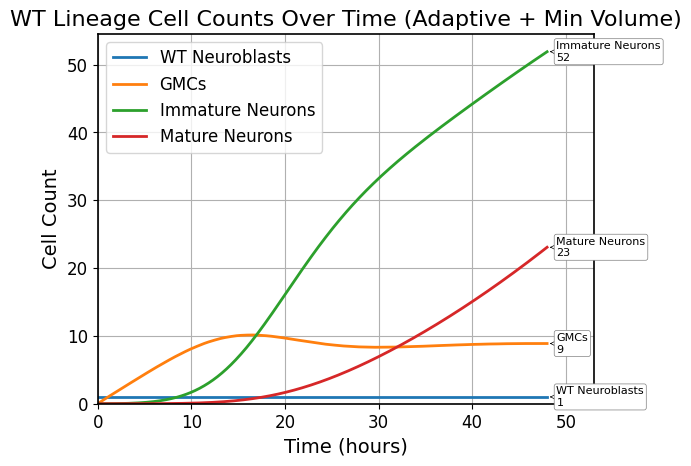

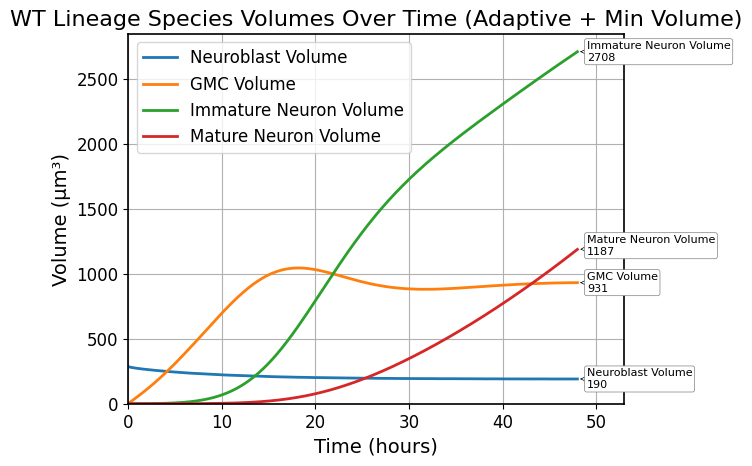

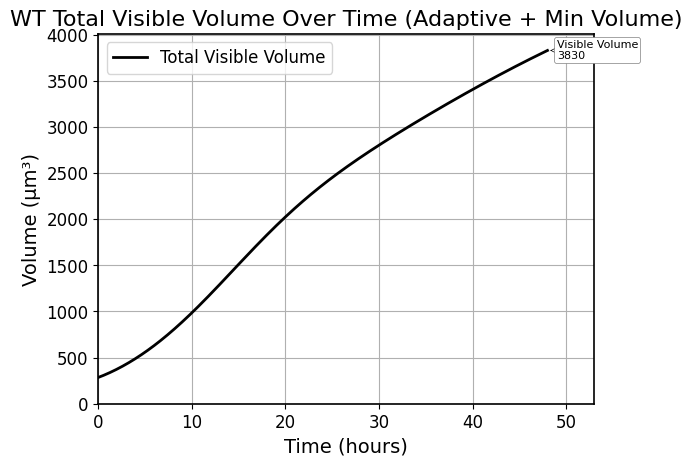

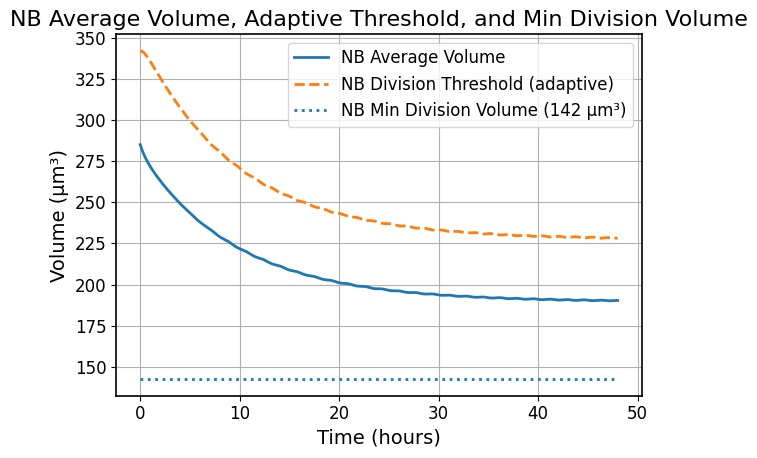

In [37]:
# --- WT params (adaptive threshold + minimum division volume) ---
nb_vol = 285
g_NB = nb_vol * 0.2 / 1.5           # NB grow to 120% initial size in 90 minutes
g_GMC = (nb_vol * 1.2 * 0.2) / 9    # GMCs add nb_vol*1.2*0.2 volume in 9 hours
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # GMC threshold = 2× their initial volume
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.0
k_Neuron = 1 / 48
tau_thresh_NB = 1.0                 # hours
V_floor_NB = nb_vol / 2.0           # minimum average NB volume required to divide

params_minVol = [
    g_NB, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    V_floor_NB
]

# Initial conditions: include Vthresh_NB state
Vthresh0 = 1.2 * nb_vol
y0_minVol = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_minVol = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_minVol,
    t_span, y0_minVol, t_eval=t_eval, args=(params_minVol,)
)

# Optional sanity: N_NB should remain 1 when sym_frac = 0
assert np.allclose(sol_minVol.y[0], 1.0, rtol=1e-12, atol=1e-12)

# --- Plot cell counts ---
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol_minVol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_minVol.t, y, label=label)

ax.set_xlim(0, sol_minVol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_minVol.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time (Adaptive + Min Volume)")
ax.grid()
ax.legend()
plt.show()

# --- Plot total volumes ---
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol_minVol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_minVol.t, y, label=label)

ax.set_xlim(0, sol_minVol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_minVol.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time (Adaptive + Min Volume)")
ax.grid()
ax.legend()
plt.show()

# --- Plot total visible lineage volume (NB + GMC + immature neurons) ---
fig, ax = plt.subplots()
total_visible_vol = sol_minVol.y[1] + sol_minVol.y[3] + sol_minVol.y[5]
ax.plot(sol_minVol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_minVol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_minVol.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time (Adaptive + Min Volume)")
ax.grid()
ax.legend()
plt.show()

# --- Plot NB avg volume vs adaptive threshold (+ show volume floor) ---
Vavg_NB = np.divide(sol_minVol.y[1], sol_minVol.y[0],
                    out=np.zeros_like(sol_minVol.y[1]),
                    where=sol_minVol.y[0] > 0)
Vthresh_NB_t = sol_minVol.y[8]

fig, ax = plt.subplots()
ax.plot(sol_minVol.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_minVol.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.hlines(V_floor_NB, sol_minVol.t[0], sol_minVol.t[-1], linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume, Adaptive Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

### mud

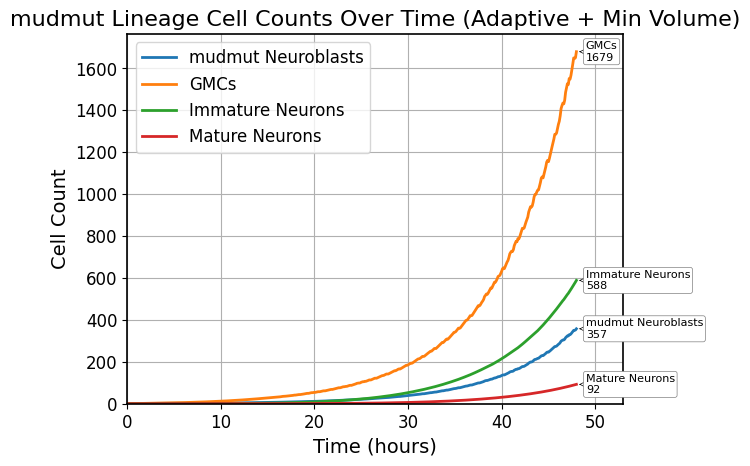

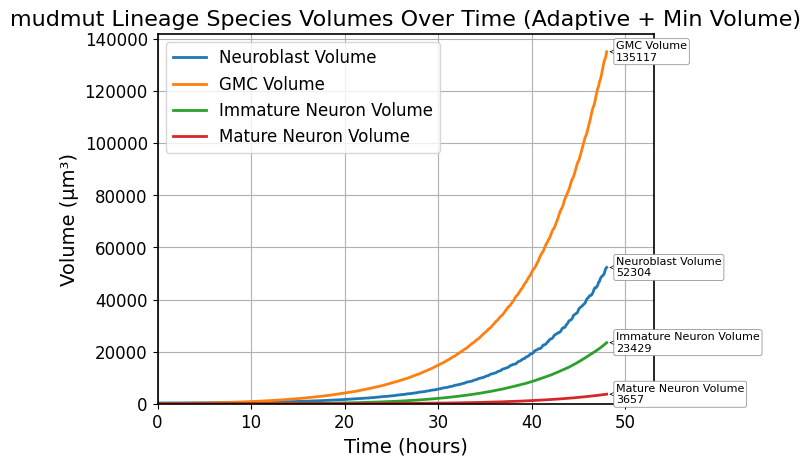

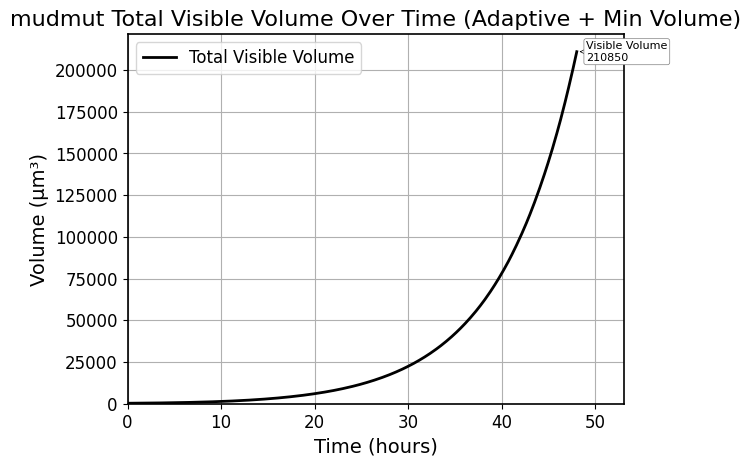

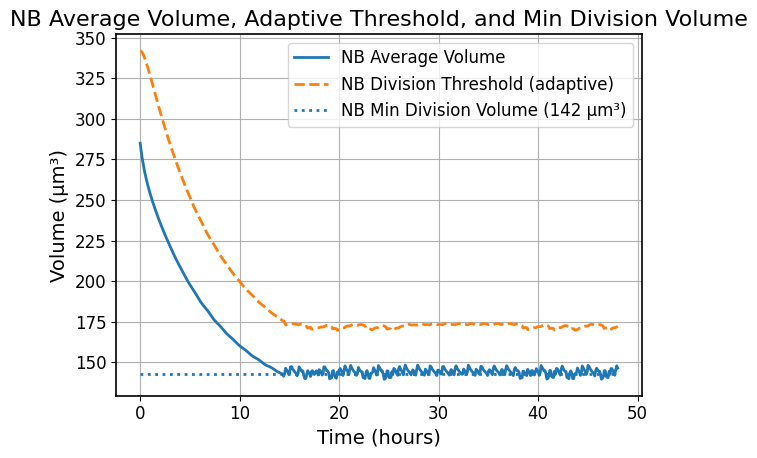

In [38]:
# --- WT params (adaptive threshold + minimum division volume) ---
nb_vol = 285
g_NB = nb_vol * 0.2 / 1.5           # NB grow to 120% initial size in 90 minutes
g_GMC = (nb_vol * 1.2 * 0.2) / 9    # GMCs add nb_vol*1.2*0.2 volume in 9 hours
V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2  # GMC threshold = 2× their initial volume
k_max_NB = 1 / 0.25
k_max_GMC = 1 / 1.5
n = 6
sym_frac = 0.15
k_Neuron = 1 / 48
tau_thresh_NB = 1.0                 # hours
V_floor_NB = nb_vol / 2.0           # minimum average NB volume required to divide

params_minVol = [
    g_NB, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    V_floor_NB
]

# Initial conditions: include Vthresh_NB state
Vthresh0 = 1.2 * nb_vol
y0_minVol = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_minVol = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_minVol,
    t_span, y0_minVol, t_eval=t_eval, args=(params_minVol,)
)

# --- Plot cell counts ---
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol_minVol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_minVol.t, y, label=label)

ax.set_xlim(0, sol_minVol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_minVol.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time (Adaptive + Min Volume)")
ax.grid()
ax.legend()
plt.show()

# --- Plot total volumes ---
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol_minVol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_minVol.t, y, label=label)

ax.set_xlim(0, sol_minVol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_minVol.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time (Adaptive + Min Volume)")
ax.grid()
ax.legend()
plt.show()

# --- Plot total visible lineage volume (NB + GMC + immature neurons) ---
fig, ax = plt.subplots()
total_visible_vol = sol_minVol.y[1] + sol_minVol.y[3] + sol_minVol.y[5]
ax.plot(sol_minVol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_minVol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_minVol.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time (Adaptive + Min Volume)")
ax.grid()
ax.legend()
plt.show()

# --- Plot NB avg volume vs adaptive threshold (+ show volume floor) ---
Vavg_NB = np.divide(sol_minVol.y[1], sol_minVol.y[0],
                    out=np.zeros_like(sol_minVol.y[1]),
                    where=sol_minVol.y[0] > 0)
Vthresh_NB_t = sol_minVol.y[8]

fig, ax = plt.subplots()
ax.plot(sol_minVol.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_minVol.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.hlines(V_floor_NB, sol_minVol.t[0], sol_minVol.t[-1], linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume, Adaptive Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

---

## 13. Modeling Volume-Dependent Division with Adaptive Threshold, Minimum Volume Requirement, and NB Growth Repression

This model extends the adaptive-threshold neuroblast (NB) division framework by incorporating **two biologically motivated constraints**:

1. **Minimum Volume Requirement:**
   Neuroblasts must reach a specified minimum **average volume** before they can divide. This prevents divisions when cells are too small, even if the adaptive division threshold would otherwise allow it.

2. **NB Growth Repression by NB Count:**
   NB growth rate decreases as the total number of neuroblasts increases, following a **decreasing Hill function**. This models negative feedback mechanisms where high NB abundance reduces their individual growth rates.

### Key Features

- **Adaptive NB Threshold:**
  The NB division threshold $ V_{\text{thresh,NB}}(t)$ relaxes toward $ 1.2 \times V_{\text{avg,NB}}(t)$ with a time constant $\tau_{\text{thresh,NB}}$:
  $$
  \frac{d}{dt} V_{\text{thresh,NB}} = \frac{1}{\tau_{\text{thresh,NB}}} \left[ 1.2\,V_{\text{avg,NB}}(t) - V_{\text{thresh,NB}}(t) \right]
  $$

- **Minimum Division Volume:**
  NB division only occurs if:
  $$
  V_{\text{avg,NB}}(t) \ge V_{\text{floor,NB}}
  $$
  Otherwise $k_{\text{NB}} = 0$.

- **NB Growth Repression:**
  The NB growth rate is scaled by a decreasing Hill function of NB count:
  $$
  g_{\text{NB,eff}}(t) = g_{\text{NB,base}} \cdot \frac{K_{\text{NB,g}}^m}{K_{\text{NB,g}}^m + N_{\text{NB}}(t)^m}
  $$
  where:
  - $K_{\text{NB,g}}$— NB count for half-maximal growth
  - $m$ — Hill coefficient controlling steepness

### Species
- $N_{\text{NB}}, V_{\text{NB}}$ — Neuroblast count and total volume
- $N_{\text{GMC}}, V_{\text{GMC}}$ — Ganglion Mother Cell count and total volume
- $N_{\text{ImNeuron}}, V_{\text{ImNeuron}}$ — Immature neuron count and total volume
- $N_{\text{MatNeuron}}, V_{\text{MatNeuron}}$ — Mature neuron count and total volume
- $V_{\text{thresh,NB}}$ — Dynamic NB division threshold

### Parameters
- **Growth & Maturation:**
  $g_{\text{NB,base}}, g_{\text{GMC}}, k_{\text{Neuron}}$
- **Division Thresholds:**
  $V_{\text{thresh,GMC}}, k_{\max,\text{NB}}, k_{\max,\text{GMC}}, n $
- **Division Symmetry:**
  $\text{sym\_frac}$ — fraction of NB divisions that are symmetric
- **Adaptive Threshold Dynamics:**
  $\tau_{\text{thresh,NB}}$ — relaxation time constant
- **Minimum Volume Floor:**
  $V_{\text{floor,NB}}$ — minimum average NB volume to allow division
- **Growth Repression:**
  $K_{\text{NB,g}}, m_{\text{growth}}$ — Hill parameters for NB count repression

### Division Rate Formulation
- **NB Division Rate** (only if $V_{\text{avg,NB}} \ge V_{\text{floor,NB}}$, otherwise set to 0):
  $$
  k_{\text{NB}}(t) =
  k_{\max,\text{NB}} \cdot \frac{V_{\text{avg,NB}}(t)^n}{V_{\text{thresh,NB}}(t)^n + V_{\text{avg,NB}}(t)^n}
  $$
- **GMC Division Rate** (volume-dependent with fixed threshold):
  $$
  k_{\text{GMC}}(t) =
  k_{\max,\text{GMC}} \cdot \frac{V_{\text{avg,GMC}}(t)^n}{V_{\text{thresh,GMC}}^n + V_{\text{avg,GMC}}(t)^n}
  $$

### Interpretation
This model enforces both **size-dependent division** and **population-level feedback** on growth, capturing more realistic biological constraints:
- Prevents division when NBs are too small
- Slows NB growth when NB counts are high
- Retains sensitivity to both volume history (through adaptive threshold) and cell count (through growth repression)

In [39]:
def neuroblast_model_volume_threshold_division_adaptive_minVol_growthRepress(t, y, params):
    """
    Adaptive NB threshold + minimum NB division volume + NB growth repression by NB count.

    Changes vs. 'adaptive_minVol' model:
      - Replace constant g_NB with g_NB_eff = g_NB_base * K^m / (K^m + N_NB^m)

    Parameter order (added the last two):
      g_NB_base, g_GMC,
      k_Neuron,
      sym_frac,
      V_thresh_GMC,
      k_max_NB, k_max_GMC,
      n,
      tau_thresh_NB,
      V_floor_NB,
      K_NB_growth, m_growth
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron,
     Vthresh_NB) = y

    (g_NB_base, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_GMC,      # fixed GMC threshold
     k_max_NB, k_max_GMC,
     n,
     tau_thresh_NB,
     V_floor_NB,
     K_NB_growth, m_growth) = params

    # --- Average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- Adaptive NB threshold toward 1.2× avg NB volume ---
    target_thresh_NB = 1.2 * Vavg_NB
    dVthresh_NB = (target_thresh_NB - Vthresh_NB) / tau_thresh_NB

    # --- NB division rate with min-volume floor ---
    if N_NB > 0 and Vthresh_NB > 0 and Vavg_NB >= V_floor_NB:
        k_NB = k_max_NB * (Vavg_NB**n) / (Vthresh_NB**n + Vavg_NB**n)
    else:
        k_NB = 0.0

    # --- GMC division rate (unchanged) ---
    if N_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # --- NB growth repression by NB count (decreasing Hill) ---
    if N_NB > 0 and K_NB_growth > 0:
        growth_repress = (K_NB_growth**m_growth) / (K_NB_growth**m_growth + N_NB**m_growth)
    else:
        growth_repress = 1.0
    g_NB_eff = g_NB_base * growth_repress

    # --- Divisions ---
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB_eff * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron,
        dVthresh_NB
    ]

### WT 

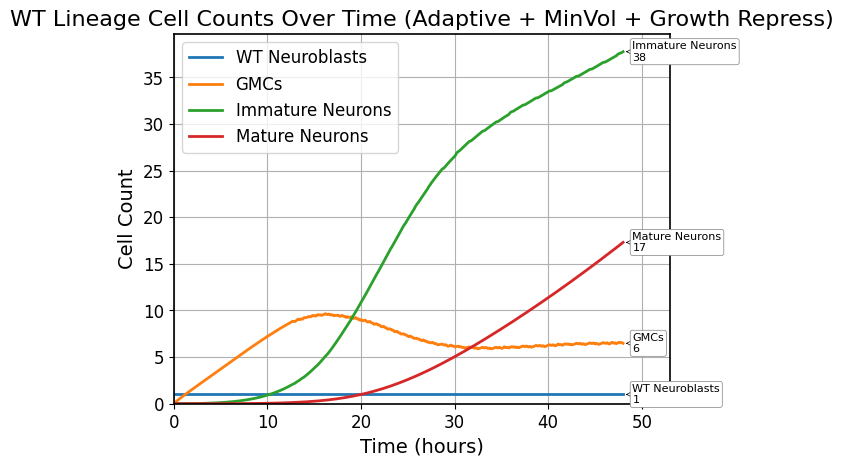

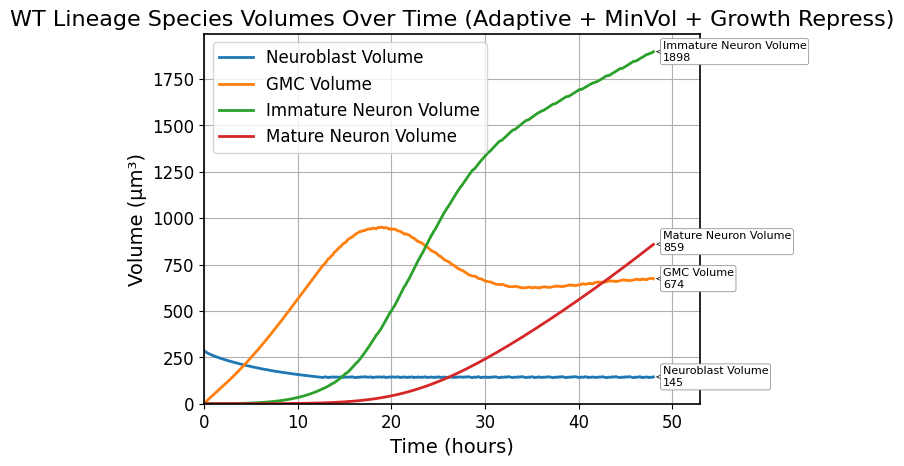

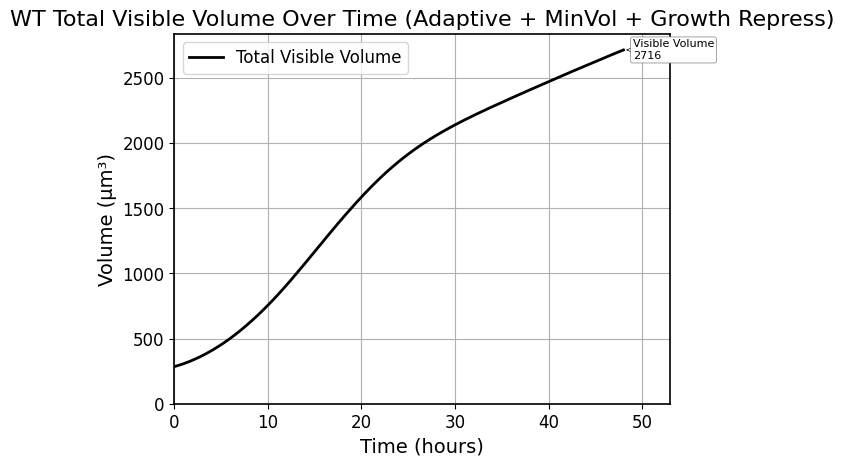

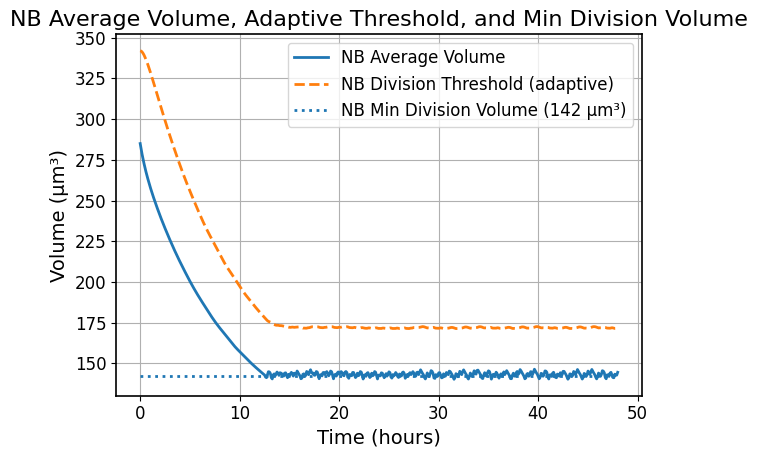

In [40]:
# --- WT params (adaptive threshold + min volume + NB growth repression) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

g_NB_base = nb_vol * 0.2 / 1.5              # NB base growth rate (volume/hr): grow to 120% of initial size in 90 min
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr): add 20% of NB*1.2 volume in 9 hours

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³), here = 2× their initial volume
k_max_NB  = 1 / 0.25                        # Max NB division rate (divisions/hr) = 1 every 15 minutes
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr) = 1 every 1.5 hours
n         = 6                               # Hill coefficient controlling threshold sharpness

sym_frac  = 0.0                             # Fraction of NB divisions that are symmetric (0 = always asymmetric)
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr) = 1 every 48 hours
tau_thresh_NB = 1.0                         # Time constant (hrs) for NB threshold adaptation toward 1.2× avg NB volume
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume (µm³) required before division is allowed

# NB growth repression by NB count (decreasing Hill)
K_NB_growth = 1.0                           # NB count at which NB growth is half-maximal
m_growth    = 2.0                           # Hill steepness for NB count repression

params_wt = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    V_floor_NB,
    K_NB_growth, m_growth
]

# Initial conditions include Vthresh_NB state
Vthresh0 = 1.2 * nb_vol
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_wt = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_minVol_growthRepress,
    t_span, y0, t_eval=t_eval, args=(params_wt,)
)

# Sanity: N_NB should remain 1 for sym_frac = 0
assert np.allclose(sol_wt.y[0], 1.0, rtol=1e-12, atol=1e-12)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data  = [sol_wt.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_wt.t, y, label=label)

ax.set_xlim(0, sol_wt.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time (Adaptive + MinVol + Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: Species total volumes ==========
fig, ax = plt.subplots()
labels_vol  = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol  = [sol_wt.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_wt.t, y, label=label)

ax.set_xlim(0, sol_wt.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time (Adaptive + MinVol + Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 3: Total visible lineage volume (NB + GMC + immature neurons) ==========
fig, ax = plt.subplots()
total_visible_vol = sol_wt.y[1] + sol_wt.y[3] + sol_wt.y[5]
ax.plot(sol_wt.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_wt.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time (Adaptive + MinVol + Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 4: NB average volume vs adaptive threshold (+ floor) ==========
Vavg_NB = np.divide(sol_wt.y[1], sol_wt.y[0], out=np.zeros_like(sol_wt.y[1]), where=sol_wt.y[0] > 0)
Vthresh_NB_t = sol_wt.y[8]

fig, ax = plt.subplots()
ax.plot(sol_wt.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_wt.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.hlines(V_floor_NB, sol_wt.t[0], sol_wt.t[-1], linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume, Adaptive Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

### mudmut

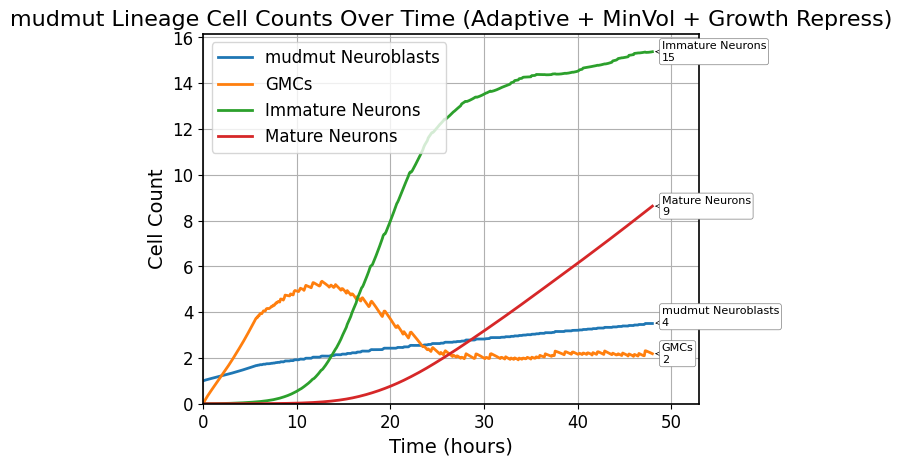

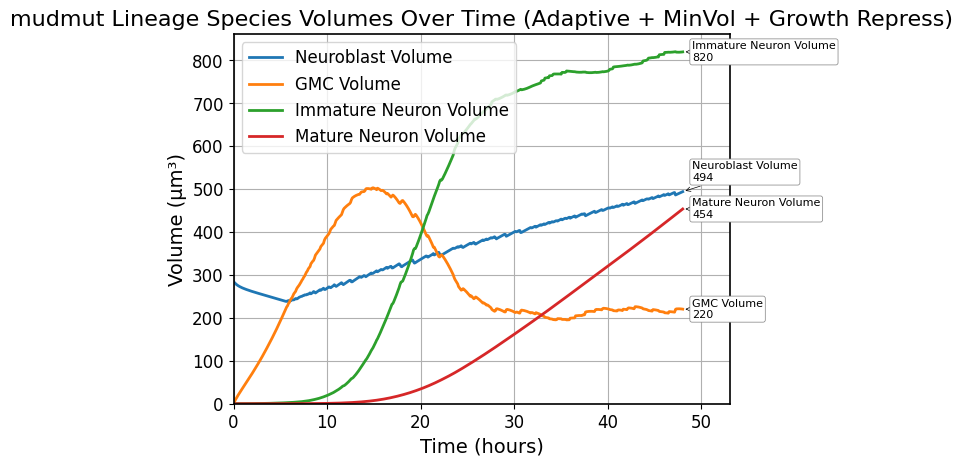

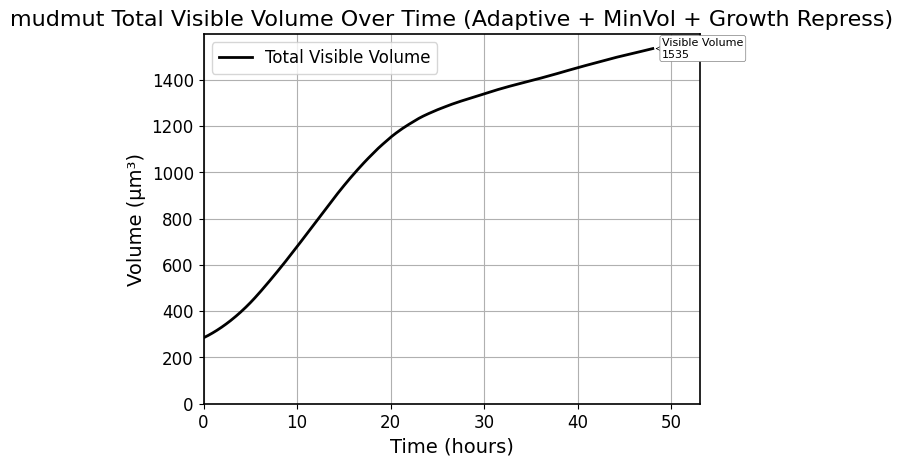

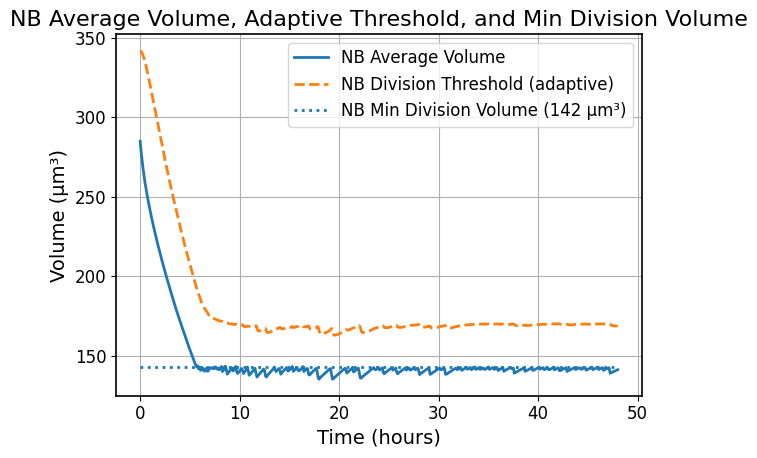

In [41]:
# --- WT params (adaptive threshold + min volume + NB growth repression) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

g_NB_base = nb_vol * 0.2 / 1.5              # NB base growth rate (volume/hr): grow to 120% of initial size in 90 min
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr): add 20% of NB*1.2 volume in 9 hours

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³), here = 2× their initial volume
k_max_NB  = 1 / 0.25                        # Max NB division rate (divisions/hr) = 1 every 15 minutes
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr) = 1 every 1.5 hours
n         = 6                               # Hill coefficient controlling threshold sharpness

sym_frac  = 0.15                            # Fraction of NB divisions that are symmetric (15% = mudmut)
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr) = 1 every 48 hours
tau_thresh_NB = 1.0                         # Time constant (hrs) for NB threshold adaptation toward 1.2× avg NB volume
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume (µm³) required before division is allowed

# NB growth repression by NB count (decreasing Hill)
K_NB_growth = 1.0                           # NB count at which NB growth is half-maximal
m_growth    = 2.0                           # Hill steepness for NB count repression

params_wt = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    V_floor_NB,
    K_NB_growth, m_growth
]

# Initial conditions include Vthresh_NB state
Vthresh0 = 1.2 * nb_vol
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_wt = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_minVol_growthRepress,
    t_span, y0, t_eval=t_eval, args=(params_wt,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data  = [sol_wt.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_wt.t, y, label=label)

ax.set_xlim(0, sol_wt.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time (Adaptive + MinVol + Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: Species total volumes ==========
fig, ax = plt.subplots()
labels_vol  = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol  = [sol_wt.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_wt.t, y, label=label)

ax.set_xlim(0, sol_wt.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time (Adaptive + MinVol + Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 3: Total visible lineage volume (NB + GMC + immature neurons) ==========
fig, ax = plt.subplots()
total_visible_vol = sol_wt.y[1] + sol_wt.y[3] + sol_wt.y[5]
ax.plot(sol_wt.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_wt.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time (Adaptive + MinVol + Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 4: NB average volume vs adaptive threshold (+ floor) ==========
Vavg_NB = np.divide(sol_wt.y[1], sol_wt.y[0], out=np.zeros_like(sol_wt.y[1]), where=sol_wt.y[0] > 0)
Vthresh_NB_t = sol_wt.y[8]

fig, ax = plt.subplots()
ax.plot(sol_wt.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_wt.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.hlines(V_floor_NB, sol_wt.t[0], sol_wt.t[-1], linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume, Adaptive Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

### Conclusions/reflections:
- Both the mudmut and the WT NBs approach the minimum division volume over time in this model, which is not what we would expect. This is because the division threshold is tied to the average NB volume over time, and if the WT NB is growing more slowly that average volume will decrease pulling down the division threshold yielding even smaller NBs in the future. I think any situation in which we tie the NB division threshold to average NB volume and then apply negative feedback on the NB growth rate will lead to this same behavior

## 14. Model 9 but NB growth rate is suppressed by total cell count (as proof of concept, we expect to see the same issue we see in model 12 where WT NB average volume approaches minimum)

In [42]:
def neuroblast_model_volume_threshold_division_adaptive_minVol_totalGrowthRepress(t, y, params):
    """
    Adaptive NB threshold + minimum NB division volume + NB growth repression by TOTAL cell count.

    Changes vs. model 12:
      - Replace NB-count repression with TOTAL-count repression:
        g_NB_eff = g_NB_base * K_total^m / (K_total^m + N_total^m),
        where N_total = N_NB + N_GMC + N_ImNeuron + N_MatNeuron

    Parameter order (last two are new names for clarity):
      g_NB_base, g_GMC,
      k_Neuron,
      sym_frac,
      V_thresh_GMC,
      k_max_NB, k_max_GMC,
      n,
      tau_thresh_NB,
      V_floor_NB,
      K_total_growth, m_growth
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron,
     Vthresh_NB) = y

    (g_NB_base, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_GMC,      # fixed GMC threshold
     k_max_NB, k_max_GMC,
     n,
     tau_thresh_NB,
     V_floor_NB,
     K_total_growth, m_growth) = params

    # --- Average volumes ---
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # --- Adaptive NB threshold toward 1.2× avg NB volume ---
    target_thresh_NB = 1.2 * Vavg_NB
    dVthresh_NB = (target_thresh_NB - Vthresh_NB) / tau_thresh_NB

    # --- NB division rate with min-volume floor ---
    if N_NB > 0 and Vthresh_NB > 0 and Vavg_NB >= V_floor_NB:
        k_NB = k_max_NB * (Vavg_NB**n) / (Vthresh_NB**n + Vavg_NB**n)
    else:
        k_NB = 0.0

    # --- GMC division rate (unchanged) ---
    if N_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # --- NB growth repression by TOTAL cell count (decreasing Hill) ---
    N_total = N_NB + N_GMC + N_ImNeuron + N_MatNeuron
    if K_total_growth > 0:
        growth_repress = (K_total_growth**m_growth) / (K_total_growth**m_growth + N_total**m_growth)
    else:
        growth_repress = 1.0
    g_NB_eff = g_NB_base * growth_repress

    # --- Divisions ---
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # --- Neuroblast dynamics ---
    dN_NB = sym_divs
    dV_NB = (
        g_NB_eff * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    # --- GMC dynamics ---
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    # --- Immature neuron dynamics ---
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    # --- Mature neuron dynamics ---
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron,
        dVthresh_NB
    ]

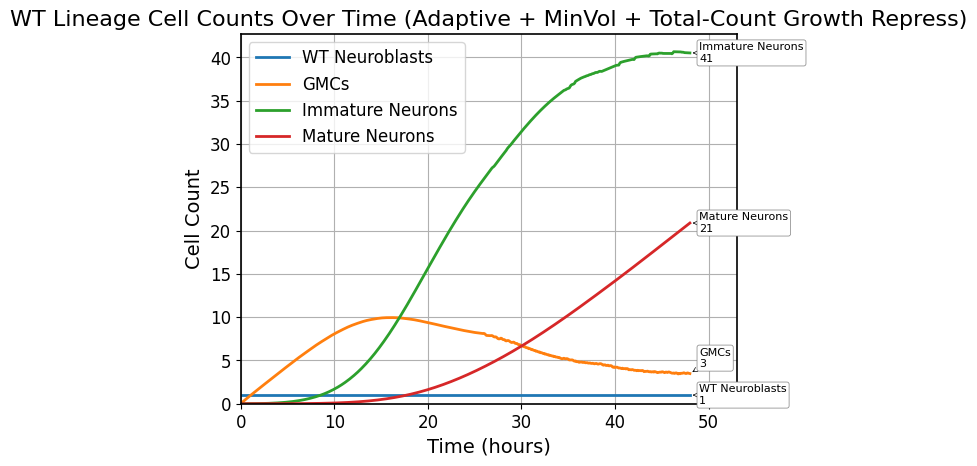

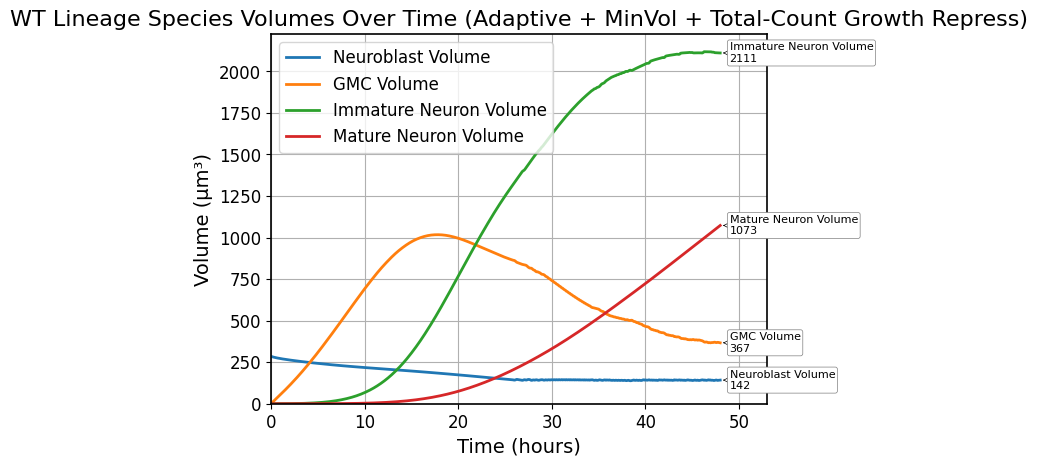

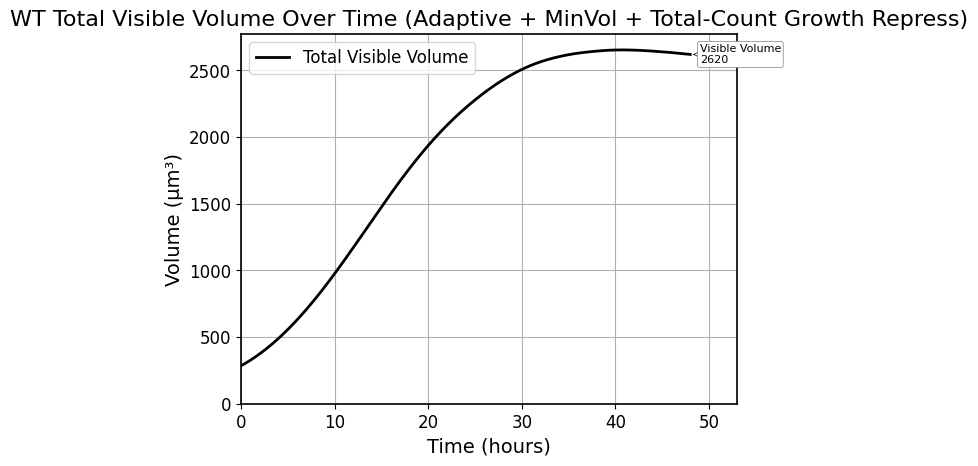

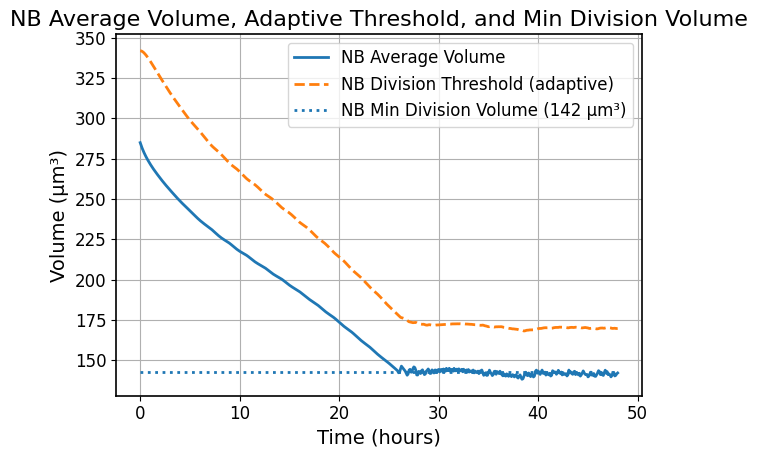

In [47]:
# --- WT params (adaptive threshold + min volume + NB growth repression by TOTAL count) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

g_NB_base = nb_vol * 0.2 / 1.5              # NB base growth rate (volume/hr): grow to 120% initial size in 90 min (pre-repression)
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr): add 20% of (NB*1.2) volume in 9 hours

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³): 2× their initial volume
k_max_NB  = 1 / 0.25                        # Max NB division rate (divisions/hr) = 1 every 15 minutes
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr) = 1 every 1.5 hours
n         = 6                               # Hill coefficient for division-threshold sharpness

sym_frac  = 0.0                             # Fraction of NB divisions that are symmetric
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr) = 1 every 48 hours
tau_thresh_NB = 1.0                         # Time constant (hrs) for NB threshold adaptation toward 1.2× avg NB volume
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume (µm³) required before division is allowed

# NB growth repression by TOTAL cell count (decreasing Hill in N_total)
K_total_growth = 40.0                       # Total cell count at which NB growth is half-maximal
m_growth       = 2.0                        # Hill steepness for total-count repression

params_wt_total = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    V_floor_NB,
    K_total_growth, m_growth
]

# Initial conditions include Vthresh_NB state
Vthresh0 = 1.2 * nb_vol
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_wt_total = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_minVol_totalGrowthRepress,
    t_span, y0, t_eval=t_eval, args=(params_wt_total,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data  = [sol_wt_total.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_wt_total.t, y, label=label)

ax.set_xlim(0, sol_wt_total.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt_total.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time (Adaptive + MinVol + Total-Count Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: Species total volumes ==========
fig, ax = plt.subplots()
labels_vol  = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol  = [sol_wt_total.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_wt_total.t, y, label=label)

ax.set_xlim(0, sol_wt_total.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt_total.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time (Adaptive + MinVol + Total-Count Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 3: Total visible lineage volume (NB + GMC + immature neurons) ==========
fig, ax = plt.subplots()
total_visible_vol = sol_wt_total.y[1] + sol_wt_total.y[3] + sol_wt_total.y[5]
ax.plot(sol_wt_total.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_wt_total.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt_total.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time (Adaptive + MinVol + Total-Count Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 4: NB avg volume vs adaptive threshold (+ floor) ==========
Vavg_NB = np.divide(sol_wt_total.y[1], sol_wt_total.y[0], out=np.zeros_like(sol_wt_total.y[1]), where=sol_wt_total.y[0] > 0)
Vthresh_NB_t = sol_wt_total.y[8]

fig, ax = plt.subplots()
ax.plot(sol_wt_total.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_wt_total.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.hlines(V_floor_NB, sol_wt_total.t[0], sol_wt_total.t[-1], linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume, Adaptive Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

Sure enough.

### mudmut

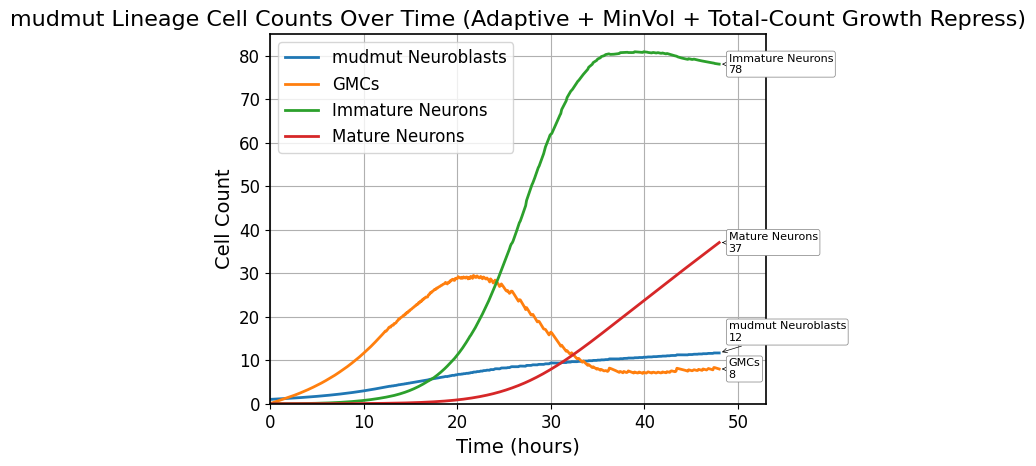

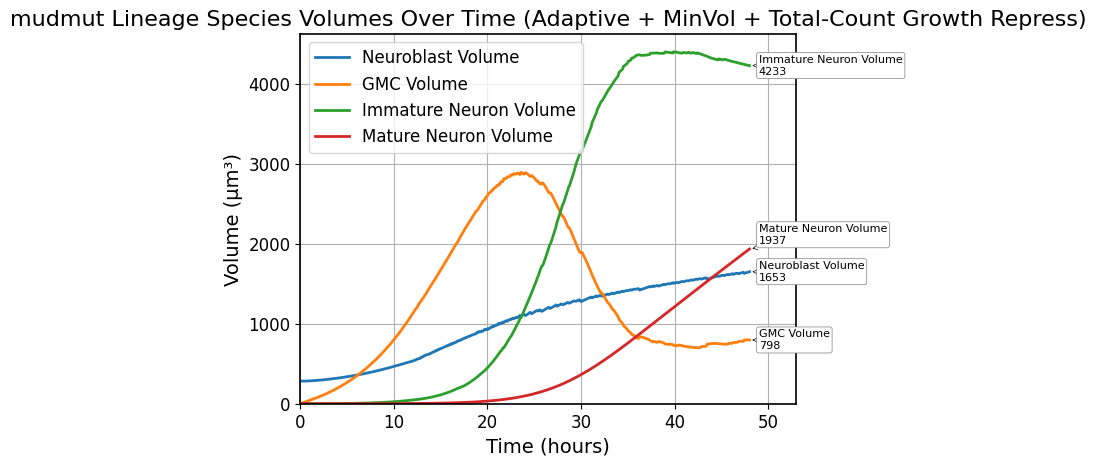

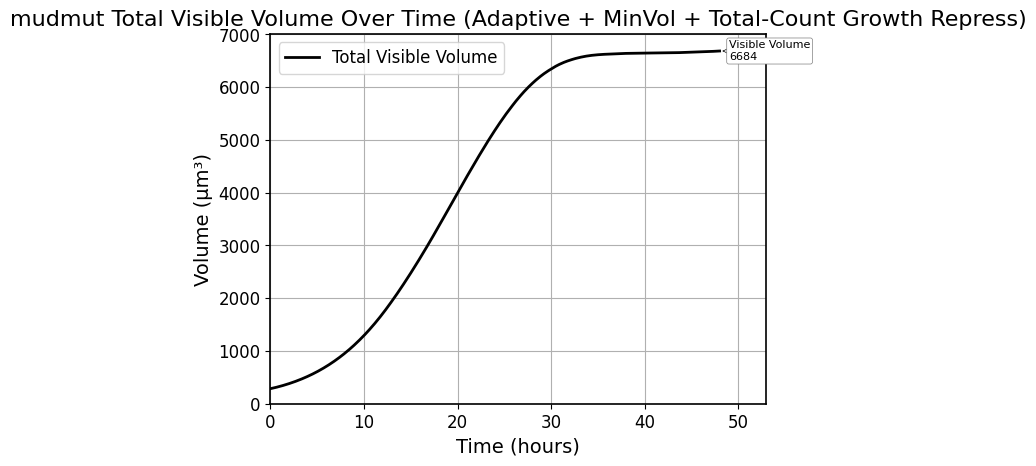

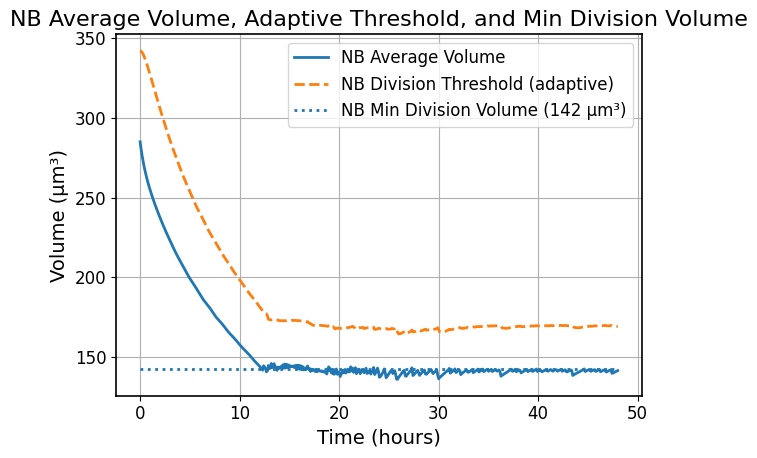

In [48]:
# --- WT params (adaptive threshold + min volume + NB growth repression by TOTAL count) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

g_NB_base = nb_vol * 0.2 / 1.5              # NB base growth rate (volume/hr): grow to 120% initial size in 90 min (pre-repression)
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr): add 20% of (NB*1.2) volume in 9 hours

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³): 2× their initial volume
k_max_NB  = 1 / 0.25                        # Max NB division rate (divisions/hr) = 1 every 15 minutes
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr) = 1 every 1.5 hours
n         = 6                               # Hill coefficient for division-threshold sharpness

sym_frac  = 0.14                            # Fraction of NB divisions that are symmetric
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr) = 1 every 48 hours
tau_thresh_NB = 1.0                         # Time constant (hrs) for NB threshold adaptation toward 1.2× avg NB volume
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume (µm³) required before division is allowed

# NB growth repression by TOTAL cell count (decreasing Hill in N_total)
K_total_growth = 40.0                       # Total cell count at which NB growth is half-maximal
m_growth       = 2.0                        # Hill steepness for total-count repression

params_wt_total = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    tau_thresh_NB,
    V_floor_NB,
    K_total_growth, m_growth
]

# Initial conditions include Vthresh_NB state
Vthresh0 = 1.2 * nb_vol
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0, Vthresh0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_wt_total = solve_ivp(
    neuroblast_model_volume_threshold_division_adaptive_minVol_totalGrowthRepress,
    t_span, y0, t_eval=t_eval, args=(params_wt_total,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data  = [sol_wt_total.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_wt_total.t, y, label=label)

ax.set_xlim(0, sol_wt_total.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt_total.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time (Adaptive + MinVol + Total-Count Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: Species total volumes ==========
fig, ax = plt.subplots()
labels_vol  = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol  = [sol_wt_total.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_wt_total.t, y, label=label)

ax.set_xlim(0, sol_wt_total.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt_total.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time (Adaptive + MinVol + Total-Count Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 3: Total visible lineage volume (NB + GMC + immature neurons) ==========
fig, ax = plt.subplots()
total_visible_vol = sol_wt_total.y[1] + sol_wt_total.y[3] + sol_wt_total.y[5]
ax.plot(sol_wt_total.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_wt_total.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_wt_total.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time (Adaptive + MinVol + Total-Count Growth Repress)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 4: NB avg volume vs adaptive threshold (+ floor) ==========
Vavg_NB = np.divide(sol_wt_total.y[1], sol_wt_total.y[0], out=np.zeros_like(sol_wt_total.y[1]), where=sol_wt_total.y[0] > 0)
Vthresh_NB_t = sol_wt_total.y[8]

fig, ax = plt.subplots()
ax.plot(sol_wt_total.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_wt_total.t, Vthresh_NB_t, '--', label="NB Division Threshold (adaptive)")
ax.hlines(V_floor_NB, sol_wt_total.t[0], sol_wt_total.t[-1], linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Average Volume, Adaptive Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

Even with the aforementioned issue, total cell repression seems to more strongly affects WT colonies than mud.